# Algoritmo Genético Versão Ensamble

Essa versão inclui:
- Otimização da rota (V1)
- Otimização da quantidade de waypoints (V2)
- Risco Inflado: Inflação das áreas não-navegáveis (V3)
- Alocação de risco (V3.5)

# 1. Utils
Essa seção contém funções auxiliares para o algoritmo. Não é necessário mexer nessa parte
(Feche essa aba)

## utils.py

In [1]:
import itertools
from scipy.stats import norm

# Support Functions
# _________________________________________________________________________________________________
def pairwise_circle(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ... (s<last>,s0)"
    a, b = itertools.tee(iterable)
    first_value = next(b, None)
    return itertools.zip_longest(a, b,fillvalue=first_value)

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def boundary(val, val_min, val_max):
  if val<val_min:
    return val_min
  if val>val_max:
    return val_max
  return val

# Ray Casting Algorithm
# _________________________________________________________________________________________________
epsilon = 0.00001  # Used on the Ray-Tracing Algorithm

def point_in_polygon(point, polygon):
    # Using ray_casting algorithm
    # https://rosettacode.org/wiki/Ray-casting_algorithm

    count = 0
    
    for vertex1, vertex2 in pairwise_circle(polygon):

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if ray_intersects_segment(point, A, B):
            count += 1

    if count % 2 == 0: # Odd
        return False 
    else:
        return True # Inside the polygon
    

def ray_intersects_segment(P, A, B):
    # P : the point from which the ray starts
    # A : the end-point of the segment with the smallest y coordinate
    #     (A must be "below" B)
    # B : the end-point of the segment with the greatest y coordinate
    #     (B must be "above" A)

    # To avoid the "ray on vertex" problem, the point is moved upward of a small quantity epsilon.
    if P.y == A.y or P.y == B.y:
        P.y += epsilon

    # Point higher or lower than polygon
    if P.y < A.y or P.y > B.y:
        return False

    # Point to the right of the polygon
    elif P.x >= max(A.x, B.x):
        return False 

    else:

        if P.x < min(A.x, B.x):
            return True

        else:

            if A.x != B.x:
                m_red = (B.y - A.y)/(B.x - A.x)
            else:
                m_red = 99999999 # Infinite


            if A.x != P.x:
                m_blue = (P.y - A.y)/(P.x - A.x)
            else:
                m_blue = 99999999 # Infinite


            if m_blue >= m_red:
                return True
            else:
                return False



# Segment Intersection
# _________________________________________________________________________________________________
def segment_in_polygon(wp1, wp2, polygon):
    # count = 0
    #print('Segment: {}-{}'.format(wp1,wp2))

    for vertex1, vertex2 in pairwise_circle(polygon):
        A = vertex1
        B = vertex2
        #if vertex1.y < vertex2.y:
        #    A = vertex1
        #    B = vertex2
        #else:
        #    A = vertex2
        #    B = vertex1
        #print('Polygon edge: {}-{}'.format(A, B))

        if segment_intersects_segment(wp1, wp2, A, B):
            return True
    return False
    # if count > 1:
    #     return True 
    # else:
    #     return False 
    

def segment_intersects_segment(p1, q1, p2, q2):
    # Returns true if line segment 'p1q1' and 'p2q2' intersect. 
    # Based on the algorithm from https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

    
    # Two segments (p1,q1) and (p2,q2) intersect if and only if one of the following two conditions is verified:
    #
    # 1. General Case:
    # – (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # – (p2, q2, p1) and (p2, q2, q1) have different orientations.
    #
    # 2. Special Case
    # – (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), and (p2, q2, q1) are all collinear and
    # – the x-projections of (p1, q1) and (p2, q2) intersect
    # – the y-projections of (p1, q1) and (p2, q2) intersect
    
    
    # Find the four orientations needed for general and 
    # special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    #print(p2, q2, p1, o3)
    o4 = orientation(p2, q2, q1) 
    #print(o1,o2,o3,o4)
    
    # 1. General case 
    if o1 != o2 and o3 != o4:
        return True  


    # 2. Special Cases 
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1 
    if o1 == 0 and on_segment(p1, p2, q1): 
        return True 
  
    # p1, q1 and q2 are colinear and q2 lies on segment p1q1 
    if o2 == 0 and on_segment(p1, q2, q1):
        return True 
  
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2 
    if o3 == 0 and on_segment(p2, p1, q2):
        return True 
  
    # p2, q2 and q1 are colinear and q1 lies on segment p2q2 
    if o4 == 0 and on_segment(p2, q1, q2):
        return True 
  
    
    # Doesn't fall in any of the above cases 
    return False 
    
    
def on_segment(p, q, r):
    # Given three colinear points p, q, r, the function checks if 
    # point q lies on line segment 'pr' 
    if (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) 
    and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y)):
        return True
    else:
        return False
    
    
def orientation(p, q, r):
    # To find orientation of ordered triplet (p, q, r). 
    # The function returns following values 
    # 0 --> p, q and r are colinear 
    # 1 --> Clockwise 
    # 2 --> Counterclockwise 
    
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/ 
    # for details of below formula. 
      
    val =( (q.y - p.y) * (r.x - q.x) 
         - ((q.x - p.x) * (r.y - q.y)))
    #print('\n---\ndebug')
    #print((q.y - p.y), (r.x - q.x), (q.x - p.x), (r.y - q.y))
    #print(val)
    if val == 0:
        return 0         # colinear

    return (1 if val > 0 else 2)  # clock or counterclock wise



# Chance Constraint
# _________________________________________________________________________________________________

def risk_total(wp, area, imprecision):   
    distance_total = math.inf

    maior = 0 #M1
    soma = 0 #M2

    if debug:
        print('maior, soma, wp_risk, distance_total')
    for A, B in pairwise(area):
        # segmento A-B

        # plano determinado pela equação ax + by + cz + d = 0, onde (a, b, c) é o vetor normal
        x = A.x - B.x
        y = A.y - B.y
        # direction_vector = (x, y) # vector in the same direction of the line that connects A and B
        # normal_vector = [-y, x] # rotate the direction vector by 90º. (x, y) -> (-y, x) 
        normal_vector = [-y/(sqrt((y**2)+(x**2))), x/(sqrt((y**2)+(x**2)))] # dividindo pela norma, normalizando o vetor

        b = (-y) * A.x + x * A.y # Coeficiente da reta

        distance = wp.x * normal_vector[0] + wp.y * normal_vector[1] - b
        #print(distance)
        distance_total = min(distance_total, distance)
        wp_risk  = risk(distance_total, imprecision)
        # maior = max(maior, wp_risk) #M1
        # soma += wp_risk #M2
        if debug:
            print(maior, soma, wp_risk, distance_total, '--', wp, A, B)
    
    

    return wp_risk
    #return maior #M1
    #return soma #M2


def risk(distance, imprecision):
    # Survival function (also defined as 1 - cdf, but sf is sometimes more accurate).
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

    # mi    : média         : location
    # sigma : desvio padrão : scale

    return norm.sf(distance, loc=0, scale=imprecision)


## visualization.py

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

import plotly.graph_objects as go

from sklearn import preprocessing


cor_area_nn    = '#25283d' # Yankees Blue
cor_area_p     = '#8f3985' # Plum
cor_area_b     = '#07beb8' # Tiffany Blue
cor_waypoints  = '#aa1155' # Jazzberry Jam
cor_ori_dest   = '#880044' # Pink Raspberry


def new_shape(vertices, color='navajowhite', lw=.25):

    assert len(vertices) >= 3, 'At least 3 vertices to form a shape'

    colors = {
        'n': cor_area_nn,
        'p': cor_area_p,
        'b': cor_area_b
    }
    
    color = colors[color] if color in colors else color
    
    codes = [Path.MOVETO]
    for _ in range(1, len(vertices)-1):
        codes.append(Path.LINETO)
    codes.append(Path.CLOSEPOLY)
    
    path = Path(vertices, codes)

    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=0.6)

    return patch


def plot_map(wp_style='-x', **kwargs):
    # Optional arguments:
    # areas, labels, origem, destino, waypoints, texts

    fig, ax = plt.subplots(figsize=(8,8)) 
    
    # Plot areas
    if 'areas' in kwargs and 'labels' in kwargs:
        areas=kwargs['areas']
        labels=kwargs['labels']
        patches = [ new_shape(vertice, color=label) for vertice, label in zip(areas, labels) ]
        for patch in patches:
            ax.add_patch(patch)
        
    # Plot origin and destination
    if 'origem' in kwargs and 'destino' in kwargs:
        origem=kwargs['origem']
        destino=kwargs['destino']
        ax.plot([origem[0], destino[0]], [origem[1], destino[1]], 'o', color=cor_ori_dest)
    
    # Plot waypoints and route
    if 'waypoints' in kwargs:
        waypoints=kwargs['waypoints']
        waypoints = list(map(list, zip(*waypoints)))
        ax.plot(waypoints[0], waypoints[1], wp_style, color=cor_waypoints, linewidth=2) #marker='x', linestyle='solid'
        if 'texts' in kwargs:
            for i, text in enumerate(kwargs['texts']):
                ax.annotate(text, (waypoints[0][i], waypoints[1][i]))
    
    if 'stress' in kwargs:
        # Plot waypoints
        if 'points' in kwargs:
            for wp, text in zip(kwargs['points'], kwargs['texts']):
                if text=='T':
                    in_color=cor_area_b
                else:
                    in_color=cor_waypoints

                ax.plot(wp[0], wp[1], wp_style, color=in_color, linewidth=2)
                ax.annotate(text, (wp[0], wp[1]))

        # Plot segments
        if 'segments' in kwargs and 'texts' in kwargs:
            i=0
            for segment, text in zip(kwargs['segments'], kwargs['texts']):
                X = [segment[0].x, segment[1].x]
                Y = [segment[0].y, segment[1].y]

                if text=='T':
                    in_color=cor_area_b
                else:
                    in_color=cor_waypoints
                ax.plot(X, Y, wp_style, color=in_color, linewidth=2)
                ax.annotate(text+str(i), (X[0], Y[0]))
                i+=1
    
    # Set size
    automin, automax = ax.get_xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = ax.get_ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    
    plt.show()
    #plt.savefig('out.png')

def plot_stats(ag_trace, normalize=True):
    dft = pd.DataFrame.from_dict(ag_trace)
    
    if normalize:
        x = dft.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        dft = pd.DataFrame(x_scaled, columns=dft.columns)

    fig = go.Figure()

    for column in dft.columns:
        fig.add_trace(go.Scatter(x=dft.index, y=dft[column], name=column))
    fig.show()

In [3]:
def vis_mapa(mapa):
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,             # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination # waypoint de destino   
    )

## data_definitions.py

In [4]:
import collections
import math

CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')
GeoPoint = collections.namedtuple('GeoPoint', 'latitude, longitude, altitude')
Version = collections.namedtuple('Version', 'major, minor')

class Mapa():
    def __init__(self, origin, destination, areas_n, inflation_rate=0.1, mode='scalar'):
        self.origin = origin           # CartesianPoint : Define o ponto de partida da rota
        self.destination = destination # CartesianPoint : Define o ponto de destino da rota
        self.areas_n = areas_n         # [area, ...]
                                       # area = [CartesianPoint(),...]      
        self.areas_n_inf = [ self._inflate_area(area, inflation_rate=inflation_rate, mode=mode) for area in areas_n ]
        
        
    def _inflate_area(self, area, inflation_rate, mode):
        if mode == 'percentage':
            # Infla uma área retangular em uma porcentagem do tamanho, alterando os valores em x% de cada vértice
            x = area[2].x - area[0].x
            y = area[1].y - area[3].y

            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec * x, area[0].y + dec * y), # left,  bottom
                CartesianPoint(area[1].x + dec * x, area[1].y + inc * y), # left,  top
                CartesianPoint(area[2].x + inc * x, area[2].y + inc * y), # right, top
                CartesianPoint(area[3].x + inc * x, area[3].y + dec * y)  # right, bottom
            ]
            new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        elif mode == 'scalar':
            # Infla uma área retangular em uma quantidade fixa
            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec, area[0].y + dec), # left,  bottom
                CartesianPoint(area[1].x + dec, area[1].y + inc), # left,  top
                CartesianPoint(area[2].x + inc, area[2].y + inc), # right, top
                CartesianPoint(area[3].x + inc, area[3].y + dec)  # right, bottom
            ]
            new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        
        return new_area



class Conversor():

    def list_geo_to_cart( l, geo_home):
        for i in l:
            yield Conversor.geo_to_cart(i, geo_home)

    def list_cart_to_geo( l, geo_home):
        for i in l:
            yield Conversor.cart_to_geo(i, geo_home)


    def geo_to_cart( geo_point, geo_home):
        
        def calc_y(lat, lat_):
            return (lat - lat_) * (10000000.0 / 90)
        def calc_x(longi, longi_, lat_):
            return (longi - longi_) * (6400000.0 * (math.cos(lat_ * math.pi / 180) * 2 * math.pi / 360))

        x = calc_x(geo_point.longitude, geo_home.longitude, geo_home.latitude)
        y = calc_y(geo_point.latitude, geo_home.latitude)

        #return CartesianPoint(x, y, geo_point.altitude)
        return CartesianPoint(x, y)


    def cart_to_geo( cartesian_point, geo_home):

        def calc_latitude_y(lat_, y):
            return ((y * 90) / 10000000.0) + lat_
        def calc_longitude_x(lat_, longi_, x):
            return ((x * 90) / (10008000 * math.cos(lat_ * math.pi / 180))) + longi_


        longitude_x = calc_longitude_x(geo_home.latitude, geo_home.longitude, cartesian_point.x)
        latitude_y = calc_latitude_y(geo_home.latitude, cartesian_point.y)

        #return GeoPoint(longitude_x, latitude_y, cartesian_point.z)
        return GeoPoint(longitude_x, latitude_y, 10)

## file_manipulation.py

In [5]:
def upload_mapa(mapa_file, mapa_id):
    mapa = mapa_file[mapa_id]

    geo_home = GeoPoint(mapa['geo_home'][1], mapa['geo_home'][0], mapa['geo_home'][2])

    areas_bonificadoras  = [ Conversor.list_geo_to_cart(area['geo_points'], geo_home) for area in mapa['areas_bonificadoras'] ]
    areas_penalizadoras  = [ Conversor.list_geo_to_cart(area['geo_points'], geo_home) for area in mapa['areas_penalizadoras'] ]
    
    areas_nao_navegaveis = []
    for area in mapa['areas_nao_navegaveis']:
        geo_points=[]
        for geo_point in area['geo_points']:
            geo_points.append(Conversor.geo_to_cart(
                GeoPoint(geo_point[1], geo_point[0], geo_point[2]) 
                , geo_home))
        geo_points.append(geo_points[0])
        areas_nao_navegaveis.append(geo_points)



    return geo_home, areas_bonificadoras, areas_penalizadoras, areas_nao_navegaveis

# 2. Algoritmo Genético
Essa seção contém a implementação do algoritmo genético, contendo a definição da classe indivíduo (Subject) e da classe do genético (Genetic).
Aqui está a implementação, não é necessário mexer, a menos que queira mudar alguma coisa na lógica da solução. **Caso somente queira mexer nos parâmetros, pule para a próxima etapa**

### Utilitários

In [6]:
import collections
import random
import time
import copy

from math import cos, sin, sqrt, ceil

from itertools import tee
#from utils import pairwise, point_in_polygon, segment_in_polygon

Gene           = collections.namedtuple('Gene', 'a e')
GeneDecoded    = collections.namedtuple('GeneDecoded', 'x y v al')

## 2.1. Definição do Indivíduo

In [7]:
class Subject():
    
    # codificação - u
    # dna = [Gene, ...]
    #     Gene = [a, e]
    #         a = float: aceleração
    #         e = float: variação angular


    # decodificação - x
    # dna_decoded = [GeneDecoded, ...]
    #     GeneDecoded = (x, y, v, al)
    #         x  = : Posição do VANT no eixo x (aka px)
    #         y  = : Posição do VANT no eixo y (aka py)
    #         v  = : Velocidade do VANT na horizontal
    #         al = : ângulo (direção) do VANT na horizontal
    def __init__(
        self,
        px0=10.,
        py0=10.,
        v0=0,
        al0=0,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,        
        e_max=3,
        a_min=-2.0,
        a_max=2.0,
        T=10,
        T_min=1,
        T_max=7,
        delta_T=1,
        m=743.0,
        mutation_prob=0.7,
        start_time=None,
        spawn_mode='random',
        version=None,
        **kwargs
    ):
        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(px0, py0, v0, al0) # GeneDecoded : objeto contendo o gene decodificado de posição 0
        self.v_min = v_min # float : Velocidade máxima (m/s)
        self.v_max = v_max # float : Velocidade mínima (m/s)
        self.e_min = e_min # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min # float : Aceleração mínima (m/s**2)
        self.a_max = a_max # float : Aceleração máxima (m/s**2)
        
        # TODO9:implementar os initialize
        
        # Modelo
        self.T_min   = T_min   # int : Valor mínimo para o horizonte de planejamento
        self.T_max   = T_max   # int : Valor máximo para o horizonte de planejamento
        self.delta_T = delta_T # int : Discretização do tempo (s) Tempo que leva de um waypoint até o outro
        self.m       = m       # float : Massa do VANT (!=0) (gramas)
    
        # Parametros do indivíduo
        self.mutation_prob = mutation_prob # float : Probabilidade de ocorrer uma mutação no dna (%)
        self.fitness       = None          # float : Fitness do indivíduo
        #self.birth_time    = None          # time  : Hora que o indivíduo é criado
        self.dna           = None          # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded   = None          # list  : DNA decodificado ([GeneDecoded, ...])
        self.spawn_mode    = spawn_mode    # str   : Tipo de incialização do DNA {'random'}
        self.start_time    = start_time    # time  : a hora em que o genético começou a rodar

        assert version, 'Algorithm version must be informed!\nEx: Version("alpha","RC")'
        if version.major == 'alpha': # Sem otimização em T
            self.T = T
            self.mutation_choices = [
                self._mutation_creep, 
                self._mutation_change
            ]
        elif version.major == 'beta': # Com otimização em T
            self.T = random.randint(T_min, T_max) # int : Horizonte de planejamento (quantidade de waypoints)
            self.mutation_choices = [
                self._mutation_remove, 
                self._mutation_insert, 
                self._mutation_creep, 
                self._mutation_change
            ]


        self.spawn(mode=spawn_mode)
        
    
    def set_fitness(self, fitness, fitness_trace, birth_time):
        self.fitness = fitness
        self.fitness_trace = fitness_trace
        #self.birth_time = birth_time
    
    
    # ---
    
    def spawn(self, mode):
        self.dna = [self._build_gene(mode) for _ in range(self.T) ]
        
    def _build_gene(self, mode='random'):
        # Inicialização aleatória gera valores com distribuição uniforme
        if mode == 'random':
            a = random.uniform(self.a_min, self.a_max)
            e = random.uniform(self.e_min, self.e_max)
            
        return Gene(a, e)
    
    # ---
    
    def decode(self):
        #self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = self._decode_gene() # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        self.birth_time = time.time() - self.start_time

    def _decode_gene(self):
        dna = self.dna
        
        # parametros
        delta_T = self.delta_T
        m = self.m
        
        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)
        
        for i in range(0, len(dna)):
            # dna
            a  = dna[i].a
            e  = dna[i].e
            
            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v  = dna_decoded[i].v
            al = dna_decoded[i].al
            
            F = self.__F(v)
        
            # Equações descritas em (Arantes 2016)
            _px = px + ( v * cos(al) * delta_T ) + ( a * cos(al) * ((delta_T**2)/2) ) 
            _py = py + ( v * sin(al) * delta_T ) + ( a * sin(al) * ((delta_T**2)/2) ) 
            _v  = v  + ( a * delta_T ) - ( (F/m) * delta_T )
            _al = al + ( e * delta_T )

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded
    
    
    def __F(self, v):
        # Equação do Arrasto
        # Disponível em https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_do_arrasto
        # Versão utilizada ((Arantes, 2016) equação 3.5)
        
        Cd  = 0.8     # float : Coeficiente de arrasto, específico para cada aeronave
                      #         (considerado Angled Cube) obtido de https://pt.wikipedia.org/wiki/Coeficiente_de_resist%C3%AAncia_aerodin%C3%A2mica
        rho = 1.225   # float : Massa específica do fuído (aka densidade) (k/m**3)
                      #         (a 15 graus Celsius) Valor de rho obtido de https://pt.m.wikipedia.org/wiki/Densidade_do_ar
        A = 1.0       # float : Área de referência # TODO: o que é isso?
        # v = v       # float : Velocidade do Vant no instante t (fornecido como parâmetro da função)
        
        F = 0.5 * Cd * rho * A * (v**2)
        
        return F
        
    
    # ---
    
    def crossover(self, parent2):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        dna = self._complete(dna, self.dna, parent2.dna)
        child = self.generate(dna)
        return child
    
    
    def _complete(self, dna, dna1, dna2):
        # Adiciona os genes restantes da diferença de tamanho entre os dois DNAs
               
        if len(dna1) > len(dna2):
            bigger  = dna1
            smaller = dna2
        else:
            bigger  = dna2
            smaller = dna1
    
        for i in range(len(smaller)-1, len(bigger)-1):
            if random.random() < 0.5:
                dna.append(bigger[i])
                
        return dna
        
    
    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna
        
        
    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            if a>self.a_max:
              a=self.a_max
            elif a < self.a_min:
              a=self.a_min

            if e>self.e_max:
              e=self.e_max
            elif e < self.e_min:
              e=self.e_min            
            
            gene = Gene(a, e)
            dna.append(gene)
            
        return dna
    
    
    def __BLX_ALpha_select_gene(self, x, y):
        # x - Gene : gene do pai 1
        # y - Gene : gene do pai 2
        alpha = random.uniform(0,1)
        d = abs(x-y)
        u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
        return u
    
    
    def generate(self, dna):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        child = copy.deepcopy(self)
        child.dna = dna
        child.decode()
        return child
    
        
    # ---
    
    def mutation(self, mutation_prob=None):
        mutation_prob = self.mutation_prob if not mutation_prob else mutation_prob # 0.7
        
        # Tem uma probabilidade mutation_prob de mutar o gene ou não
        if random.random() < mutation_prob:
            # Seleciona aleatoriamente uma das formas de mutação
            new_dna = random.choice(self.mutation_choices)(self.dna)
            # [
            #     self._mutation_remove, 
            #     self._mutation_insert, 
            #     self._mutation_creep, 
            #     self._mutation_change
            # ]
            
            if new_dna:
                self.dna = new_dna
                self.decode()
            
            return True
        return False
    
    def _mutation_change(self, dna):
        # Reinicia um gene aleatoriamente
        new_dna = []
        for gene in dna:
            if random.random() < 0.5:
                new_dna.append(self._build_gene('random'))
            else:
                new_dna.append(gene)
        
        return new_dna
    
    
    def _mutation_remove(self, dna):
        # Remove UM gene aleatório do DNA
        if len(dna) > self.T_min:
            i = random.randint(0, len(dna)-1)
            dna.pop(i)
            return dna
        return None
        
        
    def _mutation_insert(self, dna):
        # Insere UM gene aleatório no DNA em uma posição aleatória
        if len(dna) < self.T_max:
            i = random.randint(0, len(dna)-1)
            gene = self._build_gene()
            dna.insert(i, gene)
            return dna
        return None
    
    
    def _mutation_creep(self, dna):
        # Muta em um pequeno valor aleatorio todos os genes
        new_dna = []
        for gene in dna:
            a = self.__mute(gene.a, self.a_min, self.a_max)
            e = self.__mute(gene.e, self.e_min, self.e_max)

            # TODO2: otimizar
            new_gene = Gene(a, e)
            new_dna.append(new_gene)

        return new_dna
        
        
    def __mute(self, val, min_val, max_val):
        mutation_rate = random.uniform(0, max_val*0.5)
        s = random.choice([1, -1])
        val = val * (1 + (mutation_rate * s))

        # Checa se não estoura os limites
        if val>max_val:
          val=max_val
        elif val<min_val:
          val=min_val
        #val = max(val, min_val)
        #val = min(val, max_val)

        return val
    
    
    # ---
    
    def get_route(self):
        return [ [gene.x, gene.y] for gene in self.dna_decoded ]
    


        

## 2.2. Definição do Genético

In [8]:
class Genetic():
    
    def __init__(
        self, 
        Specie, 
        mapa,
        taxa_cross=1.0,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=500,
        C_cur=100,
        C_t=10,
        max_exec_time=30,
        min_precision=1.0,
        k_tournament=2,
        gps_imprecision=1,
        big_delta=1,
        version=Version('alpha','RC'),
        **kwargs
    ):
        # Modelo
        self.Specie = Specie # objeto : Definição da classe (não a instância)
        self.mapa   = mapa   # Mapa   : Mapa com as características da missão

        # Parâmetros
        self.taxa_cross      = taxa_cross      # float : Taxa de ocorrencia do crossover [0,1]
        self.population_size = population_size # int   : Quantidade máxima de indivíduos na população 
        self.C_d             = C_d             # int   : Custo associado ao fitness de destino
        self.C_obs           = C_obs           # int   : Custo associado ao fitness de obstáculos
        self.C_con           = C_con           # int   : Custo associado ao fitness de consumo de combustível
        self.C_cur           = C_cur           # int   : Custo associado ao fitness de curvatura da rota
        self.C_t             = C_t             # int   : Custo associado ao fitness do tamanho do DNA (T ou horizonte de planejamento)
        self.max_exec_time   = max_exec_time   # float : Tempo máximo de execução - Stop criteria (segundos)
        self.min_precision   = min_precision   # float : Precisão mínima de acerto ao destino (metros)
        self.k_tournament    = k_tournament    # int   : Quantidade de indivíduos disputando o torneio
        self.gps_imprecision = gps_imprecision # float : Imprecisão do GPS (metros)
        self.big_delta       = big_delta
        
        # Versionamento
        self.version = version

        # Alguns dos valores do kwargs são passados para a instanciação dos indivíduos
        self.kwargs = kwargs
        
        # Inicialização
        self.population = None 
        self.fitnesses  = None
        self.best       = None
        self.ancestry   = []
        

#         if version.minor == "RC":
#             self.__fitness_obstacles = self.__fitness_obstacles_RC
#         elif version.minor == "CC":
#             self.__fitness_obstacles = self.__fitness_obstacles_CC

        
    def run(self, max_exec_time=None, verbose=False, info=False, debug=False):
        self.max_exec_time = max_exec_time if max_exec_time else self.max_exec_time
        
        # Acompanhamento do tempo (critério de parada)
        self.start_time = time.time()
        
        # Genesis
        self.population = self._genesis(self.Specie, self.population_size)
        
        # Inicializar
        self._decode(self.population)
        
        # Avaliar
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
    
        # Escolher melhor de todos
        self.best = self.population[self.fitnesses.index(max(self.fitnesses))]
        
        
        self.trace = []
        
        while not self.stop_criteria():
            self.flag_newborn = self.population_size
            count_while = 0
            
            while not self.converge():
                self.flag_newborn = 0
                count_while += 1
                
                for i in range(ceil(self.taxa_cross * self.population_size)):
                    # Seleção por torneio
                    parent1, parent2 = self._tournament(self.population, k=self.k_tournament)
            
                    # Crossover
                    child = parent1.crossover(parent2)
                    
                    # Mutação
                    child.mutation()
                    
                    # Fitness
                    self._fitness(child, self.mapa)
                    
                    # Adicionar filho na população
                    self._insert(child, parent1, parent2)
                    
                    # Print
                    if verbose and self.flag_newbest:
                        print('  Novo melhor de todos! fit: {}'.format(self.best.fitness))
                    if debug:
                        print('\nparent1.dna', parent1.dna)
                        print('\nparent2.dna', parent2.dna)
                        print('\nchild.dna.mutation', child.dna)
                        
                        
                aux_T_dna = [len(subject.dna) for subject in self.population]
                self.trace.append({
                    'medium_fitness': sum(self.fitnesses)/self.population_size,
                    'best_fitness': self.best.fitness,
                    'newborns': self.flag_newborn,
                    'newbest': self.flag_newbest,
                    'T_medio': sum(aux_T_dna)/self.population_size,
                    'T_maior': max(aux_T_dna),
                    'T_menor': min(aux_T_dna),
                    'T_melhor': len(self.best.dna)
                })
                
                # Print
                if verbose:
                    print('Fim da geração. {} novos indivíduos'.format(self.flag_newborn))
                    print('Melhor de todos: {}'.format(self.best.fitness))
                    print('-'*20)
                        
                        
            # Reiniciar rotas
            self.population = []
            self.population = self._genesis(self.Specie, self.population_size-1)
            # Nunca matar o melhor de todos
            self.population.append(self.best)
            
            # Inicializar
            self._decode(self.population)
            
            # Avaliar
            self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
            
            # Print
            if verbose:
                print('Meteoro! Reiniciando rotas')
            if info:
                print('Meteoro! Melhor de todos:{} - count:{}'.format(self.best.fitness, count_while))
                
                
        return self.best
                      
    # ---
    
    def _insert(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        self.flag_newbest = False
        
        if child.fitness < parent1.fitness:
            self.__substitute(child, parent1)

        elif child.fitness < parent2.fitness:
            self.__substitute(child, parent2)

        if child.fitness < self.best.fitness:
            self.best = child
            self.ancestry.append(child)
            self.flag_newbest = True
    
    
    def __substitute(self, child, parent):
        i_parent = self.population.index(parent)

        self.population.remove(parent)
        self.population.append(child)

        self.fitnesses.pop(i_parent)
        self.fitnesses.append(child.fitness)
        self.flag_newborn += 1
    
    
    # ---
    
    def stop_criteria(self):
        # Para a execução depois de uma quantidade de segundos
        if (time.time() - self.start_time) >= self.max_exec_time:
            return True
        return False
    
    def converge(self):
        # Converge caso nenhum novo indivíduo seja adicinado
        if self.flag_newborn == 0:
            return True
        return False
                         
    # ---
    
    def _genesis(self, Specie, population_size):
        population = [Specie(start_time=self.start_time, version=self.version,**self.kwargs) for i in range(population_size)]
        return population 
    
    # ---
    
    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True
    
    # ---
    
    def _fitness(self, subject, mapa):
        
        fit_d   = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t   = self.__fitness_t(subject, mapa)
        
        fitness_trace = [self.C_d   * fit_d,
                         self.C_obs * fit_obs,
                         self.C_con * fit_con,
                         self.C_cur * fit_cur,
                         self.C_t   * fit_t]
        
        fitness = sum(fitness_trace)
        
        birth_time = time.time() - self.start_time
        
        subject.set_fitness(fitness, fitness_trace, birth_time)
        
        return fitness
    
    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino
        
        A = subject.dna_decoded[-1] # Último waypoint da rota
        B = mapa.destination        # Waypoint de destino
        
        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt( (B.x - A.x)**2 + (B.y - A.y)**2 )
        
        # Determina uma precisão mínima aceita
        if d < self.min_precision: # min_precision default = 1.0
            return 0
        return d

    
    # def __fitness_obstacles is an abstraction of either one of those two following functions:
    # __fitness_obstacles_RC and __fitness_obstacles_CC

#     def __fitness_obstacles_RC(self, subject, mapa):
    def __fitness_obstacles(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        count = 0
        
        for gene_decoded_t1, gene_decoded_t2  in pairwise(subject.dna_decoded):
            # Utiliza somente as áreas infladas para cálculo
            for area_n in mapa.areas_n_inf:
                wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
                wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)
                
                # Calcula se algum waypoint está dentro de algum obstáculo
                if point_in_polygon(wp1, area_n):
                    count += 1

                # Calcula se alguma conexão entre os waypoints intersecciona algum obstáculo
                if segment_in_polygon(wp1, wp2, area_n):
                    count += 1
            
        return count


    def __fitness_obstacles_CC(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        count       = 0
        
        #bigger_risk = 0 #M1
        sum_risk    = 0 #M2
    
        for gene_decoded_t1  in subject.dna_decoded:
            # Utiliza somente as áreas infladas para cálculo
            for area_n in mapa.areas_n_inf:
                wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
    
                # Alocação de Risco    
                wp_risk = risk_total(wp1, area_n, self.gps_imprecision) #M1 #M2
            
                # Modo 1: Considerar o maior risco
                # bigger_risk = max(wp_risk, bigger_risk) #M1

                # Modo 2: Considerar a soma individual de cada risco
                sum_risk += wp_risk #M2

        #prob = min(bigger_risk, 1) #M1
        #prob = min(self.big_delta - sum_risk, 1) #M2
        if self.big_delta-sum_risk > 0:
            prob=0
        else:
            prob=sum_risk-self.big_delta
            
        #print(sum_risk)
            
        return prob
    
    
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a**2 for gene in subject.dna]
        return sum(consumption)
    
        
    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [abs(gene.e) for gene in subject.dna]
        return (1/subject.e_max) * sum(curves)
        
        
    def __fitness_t(self, subject, _):
        # Prioriza rotas com menor quantidade de waypoints
        return len(subject.dna)
    
        
    # ---
        
    def _tournament(self, population, k=2):
        parents = []
        for i in range(2):
            
            local_best = random.choice(population)
            for j in range(k-1):
                # Seleciona k individuos
                a = random.choice(population)
                if a.fitness < local_best.fitness:
                    local_best = a
                    
            parents.append(local_best)
            
        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]
        
        

        
        
        

# 3. Execução
Essa seção contém a execução do AG. Aqui contém as definições dos mapas, e execução do planejador de rotas. Pode alterar os parâmetros a vontade para testar novos resultados

## 3.1. Mapas

### Mapa 1

In [9]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.5), # left, top
    (30.0, 15.5), # right, top
    (30.0, 5.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]


mapa_1 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=1)

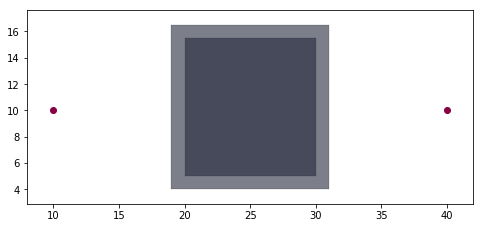

In [10]:
# Visualização desse mapa
vis_mapa(mapa_1)

### Mapa 2

In [11]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0,  8.0), # left, bottom
    (15.0, 20.0), # left, top
    (20.0, 20.0), # right, top
    (20.0,  8.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (30.0,  0.0), # left, bottom
    (30.0, 12.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  0.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_2 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=1)

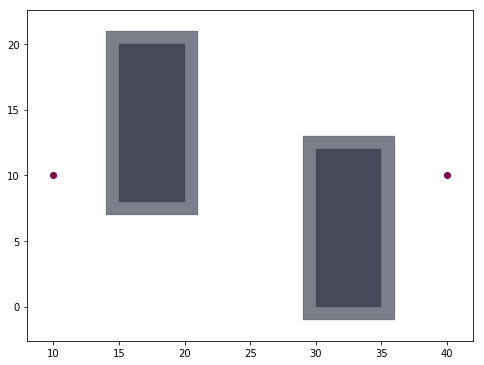

In [12]:
# Visualização desse mapa
vis_mapa(mapa_2)

### Mapa 3

In [13]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0, 11.0), # left, bottom
    (15.0, 25.0), # left, top
    (35.0, 23.0), # right, top
    (35.0, 16.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_3 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=0.5)

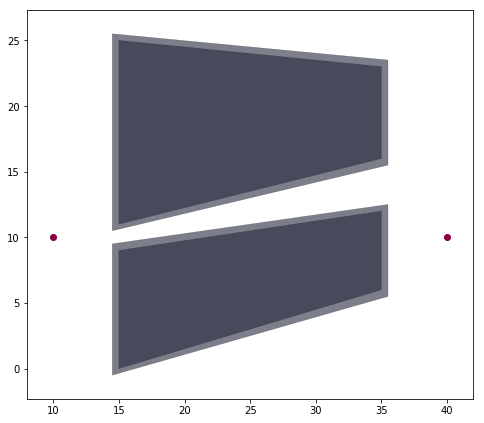

In [14]:
# Visualização desse mapa
vis_mapa(mapa_3)

### Mapa 4

In [15]:
wp_ori = CartesianPoint(40.0, 25.0)
wp_des = CartesianPoint(36.0, -22.0)

verts1 = [
    (19.0,-12.0), # left, bottom
    (15.0,0.0), # left, top
    (87.0,15.0), # right, top
    (90.0,3.0), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

# verts1 = [
#     (38.0,-9.0), # left, bottom
#     (38.0,6.0), # left, top
#     (87.0,15.0), # right, top
#     (90.0,3.0), # right, bottom
# ]
# verts1.append(verts1[0])
# verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
]
verts2.append(verts2[0])
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_4 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=0.5)

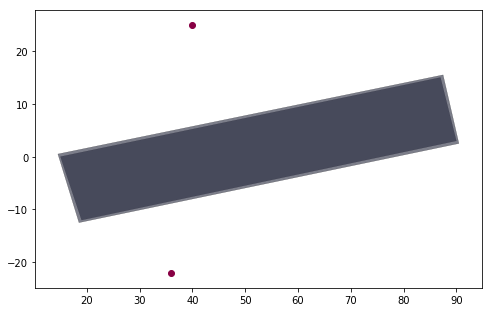

In [16]:
# Visualização desse mapa
vis_mapa(mapa_4)

## 3.2. Planejamento de Rota

In [17]:
# ===============================================================
# --------------   UTILIZE ESSE ESPAÇO --------------------------

debug = False

# Altere aqui o mapa que deseja utilizar
#mapa = mapa_1
mapa = mapa_2
#mapa = mapa_3
#mapa = mapa_4


# Inicialização do Algoritmo
ag = Genetic(Subject, mapa, 
        version = Version('beta', 'RC'),
        # Parâmetros da classe Genetic:
        taxa_cross=5,
        population_size=10,
        C_d=1000,
        C_obs=10000,
        C_con=500,
        C_cur=100,
        C_t=100,
        max_exec_time=30, # segundos
        # Parâmetros da classe Subject:
        px0=mapa.origin.x,
        py0=mapa.origin.y,
        T_min=1,
        T_max=25,
        mutation_prob=0.7
)

# ===============================================================

# Execução do AG, retorna o melhor indivíduo
best = ag.run(info=True)

# Print do DNA do melhor
print('-'*30)
for dna in best.dna:
    print(dna)
    
# Print do DNA DECODIFICADO do melhor
print('-'*30)
for dna_decoded in best.dna_decoded:
    print(dna_decoded)
    
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


# Visualização de alguns gráficos de fitness e quantidade de Ts
#plot_stats(ag.trace, normalize=True)
#plot_stats(ag.trace, normalize=False)

Meteoro! Melhor de todos:16551.580946883132 - count:20
Meteoro! Melhor de todos:15963.828638610485 - count:22
Meteoro! Melhor de todos:15963.828638610485 - count:4
Meteoro! Melhor de todos:15898.062866607776 - count:20


KeyboardInterrupt: 

In [ ]:
import pickle
pickle.dump(ag, open( "test_ag_save.p", "wb" ) )
ag_backup = pickle.load(open( "test_ag_save.p", "rb" ) )

In [ ]:
ag.__module__

In [ ]:
ag_backup.best.birth_time

In [ ]:
ag_backup

In [ ]:
debug = True
wp_teste = GeneDecoded(x=19, y=16.5, v=7.8730500357006825, al=0.23615218818588443)

risk_total(wp_teste, mapa.areas_n_inf[0], 5)

In [ ]:
 mapa.areas_n_inf[0]

#### Visualizar Detalhes do fitness

In [ ]:
best.fitness_trace
# Destino Obstáculo Consumo Curva QtdWP

#### Recuperação de Erros
Caso o AG pare no meio da execução, é possível visualizar o melhor de todos gerado até o momento mesmo assim, basta rodar a célula abaixo

In [ ]:
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


# 4. Execução da Implementação em ROS

In [ ]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Campo atras dos containers",
			"geo_points":[
				[-47.932749, -22.002332, 7], 
				[-47.932794, -22.002177, 13], 
				[-47.932664, -22.002147, 13], 
				[-47.932612, -22.002306, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Bloco de aula",
			"geo_points":[
				[-47.932099, -22.002278, 20],
				[-47.932063, -22.002396, 20],
				[-47.932772, -22.002582, 20],
				[-47.932811, -22.002465, 20]
			]
		}
    ]
}
]

In [ ]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Bloco de Aula",
			"geo_points":[
				[-47.932754, -22.002590, 7], 
				[-47.932804, -22.002485, 13], 
				[-47.932109, -22.002287, 13], 
				[-47.932072, -22.002401, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Containers",
			"geo_points":[
				[-47.933286, -22.002630, 20],
				[-47.933370, -22.002350, 20],
				[-47.933047, -22.002259, 20],
				[-47.932956, -22.002532, 20]
			]
		}
    ]
}
]

In [ ]:
import argparse

#from visualization import plot_map
#from genetic_v2_3 import Subject, Genetic 
#from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

#from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=3)



## EXECUÇÃO DO AG
ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=100,
        C_cur=500,
        C_t=100,
        max_exec_time=6000,
        #Subject,
        T_min=10,
        T_max=40,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

In [ ]:
def print_mavros(geo_points): #throws FileNotFoundException
    print('Printing mavros file...\n\n\n')
    count = 1


    current_waypoint = 1

    print('QGC WPL 120\n') # Determines the file version

    i = 0

    for geo_point in geo_points:
        print(
            str(i) + '\t'
            + str(current_waypoint) + '\t' 
            + '3\t16\t3\t0\t0\t0\t'
            + '{:10.8f}'.format(geo_point.longitude) + '\t' 
            + '{:10.8f}'.format(geo_point.latitude) + '\t'
            + '{:10.8f}'.format(geo_point.altitude) + '\t'
            + '1'
            + '\n'
        )

        current_waypoint = 0
        i+=1

    print('\n\n\nOutput print generated.')

In [ ]:
print_mavros(geo_points)

In [ ]:
mapa.areas_n

In [ ]:

areas = [ area for area in itertools.chain(mapa.areas_n) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)


In [ ]:
import argparse

#from visualization import plot_map
#from genetic_v2_3 import Subject, Genetic 
#from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

#from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG
ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=10000,
        C_con=100,
        C_cur=500,
        C_t=1,
        max_exec_time=600,
        #Subject,
        T_min=10,
        T_max=40,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

In [ ]:

best.fitness_trace
# Destino Obstáculo Consumo Curva QtdWP

In [ ]:
best = ag_teste.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas=areas,            # Mapa usado
    labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    origem=mapa.origin,      # waypoint de origem
    destino=mapa.destination, # waypoint de destino
    waypoints=best.get_route(), # rota do melhor de todos
)

# 5. Ray Casting Stress Test
Testes de estresse para verificar desempenho do algoritmo Ray Casting

## 5.1. Point in Polygon

In [ ]:
qty_points = 1000


verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    points=wps,
    wp_style='x',
    title='Ray Casting Algorithm Stress Test, wp={}'.format(qty_points),
    stress=True
)

## 5.2. Segment intersects polygon

In [ ]:
qty_segments = 15

verts1 = [
    (2.5, 2.5), # left, bottom
    (2.5, 4.5), # left, top
    (4.5, 4.5), # right, top
    (4.5, 2.5), # right, bottom
]
verts1.append(verts1[0])
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
segments = []
for i in range(qty_segments):
    x = random.uniform(1,6)
    y = random.uniform(1,6)
    wp1 = CartesianPoint(x,y)

    x = random.uniform(1,6)
    y = random.uniform(1,6)
    wp2 = CartesianPoint(x,y)

    segment = [wp1, wp2]
    segments.append(segment)
    texts.append(str(segment_in_polygon(wp1, wp2, verts1))[0])
    
plot_map(
    areas=[verts1], 
    labels=['n'], 
    texts=texts,
    segments=segments,
    wp_style='-x',
    title='Ray Casting Algorithm Stress Test, wp={}'.format(qty_segments),
    stress=True
)

# 6. Automated Experiments

## Def

In [25]:
debug = False

# Altere aqui o mapa que deseja utilizar
#mapa = mapa_1
#mapa = mapa_2
#mapa = mapa_3
#mapa = mapa_4

def run_ag(mapa):

    # Inicialização do Algoritmo
    ag = Genetic(Subject, mapa, 
            version = Version('beta', 'RC'),
            # Parâmetros da classe Genetic:
            taxa_cross=5,
            population_size=10,
            C_d=1000,
            C_obs=10000,
            C_con=500,
            C_cur=100,
            C_t=100,
            max_exec_time=1200, # segundos
            # Parâmetros da classe Subject:
            px0=mapa.origin.x,
            py0=mapa.origin.y,
            T=10,
            T_min=1,
            T_max=25,
            mutation_prob=0.7
    )

    # Execução do AG, retorna o melhor indivíduo
    best = ag.run(info=True)

    # Print do DNA do melhor
    print('-'*30)
    for dna in best.dna:
        print(dna)
        
    # Print do DNA DECODIFICADO do melhor
    print('-'*30)
    for dna_decoded in best.dna_decoded:
        print(dna_decoded)
        
    best = ag.best

    # Visualização do Mapa usado, com a rota do melhor de todos
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas=areas,            # Mapa usado
        labels=tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        origem=mapa.origin,      # waypoint de origem
        destino=mapa.destination, # waypoint de destino
        waypoints=best.get_route(), # rota do melhor de todos
    )


    # Visualização de alguns gráficos de fitness e quantidade de Ts
    #plot_stats(ag.trace, normalize=True)
    #plot_stats(ag.trace, normalize=False)

    return ag

## Run

In [26]:
import pickle

In [27]:
tests = {
    'mapa1':{
        'ags': [],
        'res': []
    },
    'mapa2':{
        'ags': [],
        'res': []
    },
    'mapa3':{
        'ags': [],
        'res': []
    },
    'mapa4':{
        'ags': [],
        'res': []
    }
}

Meteoro! Melhor de todos:30471.833332419144 - count:21
Meteoro! Melhor de todos:30233.963154542886 - count:8
Meteoro! Melhor de todos:29587.81370198816 - count:10
Meteoro! Melhor de todos:29587.81370198816 - count:12
Meteoro! Melhor de todos:29414.574178460534 - count:29
Meteoro! Melhor de todos:29414.574178460534 - count:13
Meteoro! Melhor de todos:29051.969581867044 - count:10
Meteoro! Melhor de todos:28676.10021798262 - count:12
Meteoro! Melhor de todos:28672.877054012646 - count:12
Meteoro! Melhor de todos:28604.865059829994 - count:42
Meteoro! Melhor de todos:28604.865059829994 - count:13
Meteoro! Melhor de todos:28604.865059829994 - count:12
Meteoro! Melhor de todos:28604.865059829994 - count:18
Meteoro! Melhor de todos:28604.865059829994 - count:19
Meteoro! Melhor de todos:28604.865059829994 - count:18
Meteoro! Melhor de todos:28604.865059829994 - count:10
Meteoro! Melhor de todos:28604.865059829994 - count:9
Meteoro! Melhor de todos:28604.865059829994 - count:15
Meteoro! Melhor

Meteoro! Melhor de todos:28521.902824519337 - count:21
Meteoro! Melhor de todos:28521.902824519337 - count:18
Meteoro! Melhor de todos:28521.902824519337 - count:7
Meteoro! Melhor de todos:28521.902824519337 - count:16
Meteoro! Melhor de todos:28521.902824519337 - count:17
Meteoro! Melhor de todos:28521.902824519337 - count:16
Meteoro! Melhor de todos:28521.902824519337 - count:11
Meteoro! Melhor de todos:28521.902824519337 - count:10
Meteoro! Melhor de todos:28521.902824519337 - count:11
Meteoro! Melhor de todos:28521.902824519337 - count:10
Meteoro! Melhor de todos:28521.902824519337 - count:13
Meteoro! Melhor de todos:28521.902824519337 - count:14
Meteoro! Melhor de todos:28521.902824519337 - count:13
Meteoro! Melhor de todos:28521.902824519337 - count:4
Meteoro! Melhor de todos:28521.902824519337 - count:9
Meteoro! Melhor de todos:28521.902824519337 - count:21
Meteoro! Melhor de todos:28521.902824519337 - count:19
Meteoro! Melhor de todos:28521.902824519337 - count:13
Meteoro! Melh

Meteoro! Melhor de todos:28512.236597322324 - count:29
Meteoro! Melhor de todos:28512.236597322324 - count:11
Meteoro! Melhor de todos:28512.236597322324 - count:15
Meteoro! Melhor de todos:28512.236597322324 - count:8
Meteoro! Melhor de todos:28512.236597322324 - count:12
Meteoro! Melhor de todos:28512.236597322324 - count:15
Meteoro! Melhor de todos:28512.233698056272 - count:24
Meteoro! Melhor de todos:28512.233698056272 - count:18
Meteoro! Melhor de todos:28512.233698056272 - count:16
Meteoro! Melhor de todos:28512.233698056272 - count:14
Meteoro! Melhor de todos:28512.233698056272 - count:13
Meteoro! Melhor de todos:28512.233698056272 - count:6
Meteoro! Melhor de todos:28512.233698056272 - count:7
Meteoro! Melhor de todos:28512.233698056272 - count:18
Meteoro! Melhor de todos:28512.233698056272 - count:11
Meteoro! Melhor de todos:28512.233698056272 - count:13
Meteoro! Melhor de todos:28512.233698056272 - count:23
Meteoro! Melhor de todos:28512.233698056272 - count:23
Meteoro! Melh

Meteoro! Melhor de todos:28277.946357401586 - count:16
Meteoro! Melhor de todos:28277.946357401586 - count:19
Meteoro! Melhor de todos:28277.605246593732 - count:15
Meteoro! Melhor de todos:28277.605246593732 - count:19
Meteoro! Melhor de todos:28277.605246593732 - count:13
Meteoro! Melhor de todos:28277.605246593732 - count:16
Meteoro! Melhor de todos:28277.605246593732 - count:12
Meteoro! Melhor de todos:28277.605246593732 - count:13
Meteoro! Melhor de todos:28277.605246593732 - count:11
Meteoro! Melhor de todos:28277.364141138893 - count:23
Meteoro! Melhor de todos:28277.364141138893 - count:25
Meteoro! Melhor de todos:28277.364141138893 - count:10
Meteoro! Melhor de todos:28277.364141138893 - count:8
Meteoro! Melhor de todos:28277.364141138893 - count:5
Meteoro! Melhor de todos:28277.364141138893 - count:17
Meteoro! Melhor de todos:28277.364141138893 - count:9
Meteoro! Melhor de todos:28277.364141138893 - count:31
Meteoro! Melhor de todos:28277.364141138893 - count:17
Meteoro! Melh

Meteoro! Melhor de todos:28224.21903204198 - count:11
Meteoro! Melhor de todos:28224.21903204198 - count:8
Meteoro! Melhor de todos:28224.21903204198 - count:13
Meteoro! Melhor de todos:28222.405746725883 - count:21
Meteoro! Melhor de todos:28222.405746725883 - count:10
Meteoro! Melhor de todos:28218.412592323155 - count:24
Meteoro! Melhor de todos:28218.412592323155 - count:19
Meteoro! Melhor de todos:28217.579411232287 - count:19
Meteoro! Melhor de todos:28217.579411232287 - count:8
Meteoro! Melhor de todos:28217.579411232287 - count:17
Meteoro! Melhor de todos:28217.254242439627 - count:35
Meteoro! Melhor de todos:28217.254242439627 - count:10
Meteoro! Melhor de todos:28217.254242439627 - count:20
Meteoro! Melhor de todos:28217.254242439627 - count:16
Meteoro! Melhor de todos:28216.915475342375 - count:21
Meteoro! Melhor de todos:28216.915475342375 - count:35
Meteoro! Melhor de todos:28216.915475342375 - count:6
Meteoro! Melhor de todos:28216.915475342375 - count:10
Meteoro! Melhor 

Meteoro! Melhor de todos:28207.806363813033 - count:15
Meteoro! Melhor de todos:28207.806363813033 - count:12
Meteoro! Melhor de todos:28207.806363813033 - count:5
Meteoro! Melhor de todos:28207.806363813033 - count:10
Meteoro! Melhor de todos:28207.739728870383 - count:21
Meteoro! Melhor de todos:28207.739728870383 - count:12
Meteoro! Melhor de todos:28207.739728870383 - count:16
Meteoro! Melhor de todos:28207.739728870383 - count:13
Meteoro! Melhor de todos:28207.739728870383 - count:22
Meteoro! Melhor de todos:28207.739728870383 - count:13
Meteoro! Melhor de todos:28207.739728870383 - count:18
Meteoro! Melhor de todos:28207.739728870383 - count:7
Meteoro! Melhor de todos:28207.739728870383 - count:10
Meteoro! Melhor de todos:28207.739728870383 - count:13
Meteoro! Melhor de todos:28207.739728870383 - count:13
Meteoro! Melhor de todos:28207.739728870383 - count:9
Meteoro! Melhor de todos:28207.739728870383 - count:9
Meteoro! Melhor de todos:28207.739728870383 - count:15
Meteoro! Melho

Meteoro! Melhor de todos:28207.2354722938 - count:12
Meteoro! Melhor de todos:28207.2354722938 - count:14
Meteoro! Melhor de todos:28207.2354722938 - count:12
Meteoro! Melhor de todos:28207.2354722938 - count:8
Meteoro! Melhor de todos:28207.2354722938 - count:23
Meteoro! Melhor de todos:28207.2354722938 - count:13
Meteoro! Melhor de todos:28207.2354722938 - count:20
Meteoro! Melhor de todos:28207.2354722938 - count:21
Meteoro! Melhor de todos:28207.2354722938 - count:16
Meteoro! Melhor de todos:28207.2354722938 - count:10
Meteoro! Melhor de todos:28207.2354722938 - count:15
Meteoro! Melhor de todos:28207.2354722938 - count:11
Meteoro! Melhor de todos:28207.2354722938 - count:24
Meteoro! Melhor de todos:28207.2354722938 - count:15
Meteoro! Melhor de todos:28207.2354722938 - count:14
Meteoro! Melhor de todos:28207.2354722938 - count:16
Meteoro! Melhor de todos:28207.2354722938 - count:28
Meteoro! Melhor de todos:28207.2354722938 - count:10
Meteoro! Melhor de todos:28206.729869518982 - c

Meteoro! Melhor de todos:28198.894094765288 - count:18
Meteoro! Melhor de todos:28198.894094765288 - count:12
Meteoro! Melhor de todos:28198.894094765288 - count:23
Meteoro! Melhor de todos:28198.894094765288 - count:12
Meteoro! Melhor de todos:28198.894094765288 - count:17
Meteoro! Melhor de todos:28198.894094765288 - count:16
Meteoro! Melhor de todos:28198.894094765288 - count:11
Meteoro! Melhor de todos:28198.894094765288 - count:7
Meteoro! Melhor de todos:28198.894094765288 - count:11
Meteoro! Melhor de todos:28198.894094765288 - count:22
Meteoro! Melhor de todos:28198.894094765288 - count:24
Meteoro! Melhor de todos:28198.894094765288 - count:12
Meteoro! Melhor de todos:28198.894094765288 - count:11
Meteoro! Melhor de todos:28198.894094765288 - count:12
Meteoro! Melhor de todos:28198.894094765288 - count:13
Meteoro! Melhor de todos:28198.894094765288 - count:14
Meteoro! Melhor de todos:28198.894094765288 - count:15
Meteoro! Melhor de todos:28198.894094765288 - count:19
Meteoro! Me

Meteoro! Melhor de todos:28194.41342402819 - count:11
Meteoro! Melhor de todos:28194.41342402819 - count:20
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:19
Meteoro! Melhor de todos:28194.41342402819 - count:12
Meteoro! Melhor de todos:28194.41342402819 - count:16
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:9
Meteoro! Melhor de todos:28194.41342402819 - count:14
Meteoro! Melhor de todos:28194.41342402819 - count:15
Meteoro! Melhor de todos:28194.41342402819 - count:19
Meteoro! Melhor de todos:28194.41342402819 - count:9
Meteoro! Melhor de todos:28194.41342402819 - count:19
Meteoro! Melhor de todos:28194.41342402819 - count:9
Meteoro! Melhor de todos:28194.

Meteoro! Melhor de todos:28185.05223007032 - count:12
Meteoro! Melhor de todos:28185.05223007032 - count:21
Meteoro! Melhor de todos:28185.05223007032 - count:17
Meteoro! Melhor de todos:28185.05223007032 - count:17
Meteoro! Melhor de todos:28185.05223007032 - count:19
Meteoro! Melhor de todos:28185.05223007032 - count:8
Meteoro! Melhor de todos:28185.05223007032 - count:19
Meteoro! Melhor de todos:28185.05223007032 - count:18
Meteoro! Melhor de todos:28185.05223007032 - count:20
Meteoro! Melhor de todos:28185.05223007032 - count:9
Meteoro! Melhor de todos:28185.05223007032 - count:8
Meteoro! Melhor de todos:28185.05223007032 - count:22
Meteoro! Melhor de todos:28185.05223007032 - count:23
Meteoro! Melhor de todos:28185.05223007032 - count:14
Meteoro! Melhor de todos:28185.05223007032 - count:15
Meteoro! Melhor de todos:28185.05223007032 - count:13
Meteoro! Melhor de todos:28185.05223007032 - count:22
Meteoro! Melhor de todos:28185.05223007032 - count:21
Meteoro! Melhor de todos:28185.

Meteoro! Melhor de todos:28184.607182404074 - count:12
Meteoro! Melhor de todos:28184.607182404074 - count:15
Meteoro! Melhor de todos:28184.607182404074 - count:13
Meteoro! Melhor de todos:28184.607182404074 - count:11
Meteoro! Melhor de todos:28184.607182404074 - count:15
Meteoro! Melhor de todos:28184.607182404074 - count:12
Meteoro! Melhor de todos:28184.607182404074 - count:8
Meteoro! Melhor de todos:28184.607182404074 - count:24
Meteoro! Melhor de todos:28184.607182404074 - count:13
Meteoro! Melhor de todos:28184.607182404074 - count:20
Meteoro! Melhor de todos:28184.607182404074 - count:10
Meteoro! Melhor de todos:28184.607182404074 - count:12
Meteoro! Melhor de todos:28184.607182404074 - count:20
Meteoro! Melhor de todos:28184.607182404074 - count:10
Meteoro! Melhor de todos:28184.607182404074 - count:17
Meteoro! Melhor de todos:28184.607182404074 - count:18
Meteoro! Melhor de todos:28184.607182404074 - count:25
Meteoro! Melhor de todos:28184.607182404074 - count:13
Meteoro! Me

Meteoro! Melhor de todos:28184.551272899538 - count:19
Meteoro! Melhor de todos:28184.551272899538 - count:9
Meteoro! Melhor de todos:28184.551272899538 - count:19
Meteoro! Melhor de todos:28184.551272899538 - count:14
Meteoro! Melhor de todos:28184.551272899538 - count:9
Meteoro! Melhor de todos:28184.551272899538 - count:9
Meteoro! Melhor de todos:28184.551272899538 - count:12
Meteoro! Melhor de todos:28184.551272899538 - count:18
Meteoro! Melhor de todos:28184.551272899538 - count:13
Meteoro! Melhor de todos:28184.551272899538 - count:12
Meteoro! Melhor de todos:28184.551272899538 - count:16
Meteoro! Melhor de todos:28184.551272899538 - count:18
Meteoro! Melhor de todos:28184.551272899538 - count:26
Meteoro! Melhor de todos:28184.551272899538 - count:16
Meteoro! Melhor de todos:28184.551272899538 - count:19
Meteoro! Melhor de todos:28184.551272899538 - count:10
Meteoro! Melhor de todos:28184.551272899538 - count:20
Meteoro! Melhor de todos:28184.551272899538 - count:31
Meteoro! Melh

Meteoro! Melhor de todos:28184.52213898253 - count:28
Meteoro! Melhor de todos:28184.52213898253 - count:20
Meteoro! Melhor de todos:28184.52213898253 - count:15
Meteoro! Melhor de todos:28184.52213898253 - count:18
Meteoro! Melhor de todos:28184.52213898253 - count:21
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:28184.52213898253 - count:23
Meteoro! Melhor de todos:28184.52213898253 - count:14
Meteoro! Melhor de todos:28184.52213898253 - count:14
Meteoro! Melhor de todos:28184.52213898253 - count:10
Meteoro! Melhor de todos:28184.52213898253 - count:14
Meteoro! Melhor de todos:28184.52213898253 - count:22
Meteoro! Melhor de todos:28184.52213898253 - count:10
Meteoro! Melhor de todos:28184.52213898253 - count:28
Meteoro! Melhor de todos:28184.52213898253 - count:23
Meteoro! Melhor de todos:28184.52213898253 - count:7
Meteoro! Melhor de todos:28184.52213898253 - count:13
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:2818

Meteoro! Melhor de todos:28184.52213898253 - count:17
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:28184.52213898253 - count:20
Meteoro! Melhor de todos:28184.52213898253 - count:11
Meteoro! Melhor de todos:28184.52213898253 - count:22
Meteoro! Melhor de todos:28184.52213898253 - count:16
Meteoro! Melhor de todos:28184.52213898253 - count:24
Meteoro! Melhor de todos:28184.52213898253 - count:15
Meteoro! Melhor de todos:28184.52213898253 - count:15
Meteoro! Melhor de todos:28184.52213898253 - count:10
Meteoro! Melhor de todos:28184.52213898253 - count:17
Meteoro! Melhor de todos:28184.52213898253 - count:17
Meteoro! Melhor de todos:28184.52213898253 - count:25
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:28184.52213898253 - count:21
Meteoro! Melhor de todos:28184.52213898253 - count:11
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:28184.52213898253 - count:14
Meteoro! Melhor de todos:281

Meteoro! Melhor de todos:28184.52213898253 - count:11
Meteoro! Melhor de todos:28184.52213898253 - count:10
Meteoro! Melhor de todos:28184.52213898253 - count:15
Meteoro! Melhor de todos:28184.52213898253 - count:14
Meteoro! Melhor de todos:28184.52213898253 - count:21
Meteoro! Melhor de todos:28184.52213898253 - count:13
Meteoro! Melhor de todos:28184.52213898253 - count:7
Meteoro! Melhor de todos:28184.52213898253 - count:9
Meteoro! Melhor de todos:28184.52213898253 - count:20
Meteoro! Melhor de todos:28184.52213898253 - count:11
Meteoro! Melhor de todos:28184.52213898253 - count:62
Meteoro! Melhor de todos:28184.52213898253 - count:15
Meteoro! Melhor de todos:28184.52213898253 - count:16
Meteoro! Melhor de todos:28184.52213898253 - count:13
Meteoro! Melhor de todos:28184.52213898253 - count:22
Meteoro! Melhor de todos:28184.52213898253 - count:12
Meteoro! Melhor de todos:28184.52213898253 - count:20
Meteoro! Melhor de todos:28184.52213898253 - count:19
Meteoro! Melhor de todos:28184

Meteoro! Melhor de todos:28184.520109284826 - count:15
Meteoro! Melhor de todos:28184.520109284826 - count:21
Meteoro! Melhor de todos:28183.683301580164 - count:51
Meteoro! Melhor de todos:28183.683301580164 - count:10
Meteoro! Melhor de todos:28183.683301580164 - count:21
Meteoro! Melhor de todos:28183.683301580164 - count:9
Meteoro! Melhor de todos:28183.683301580164 - count:9
Meteoro! Melhor de todos:28183.683301580164 - count:28
Meteoro! Melhor de todos:28183.683301580164 - count:15
Meteoro! Melhor de todos:28183.683301580164 - count:10
Meteoro! Melhor de todos:28183.683301580164 - count:12
Meteoro! Melhor de todos:28183.683301580164 - count:13
Meteoro! Melhor de todos:28183.683301580164 - count:9
Meteoro! Melhor de todos:28183.683301580164 - count:12
Meteoro! Melhor de todos:28183.683301580164 - count:17
Meteoro! Melhor de todos:28183.683301580164 - count:14
Meteoro! Melhor de todos:28183.683301580164 - count:16
Meteoro! Melhor de todos:28183.683301580164 - count:8
Meteoro! Melho

Meteoro! Melhor de todos:28180.394159288262 - count:18
Meteoro! Melhor de todos:28180.394159288262 - count:12
Meteoro! Melhor de todos:28180.394159288262 - count:14
Meteoro! Melhor de todos:28180.394159288262 - count:6
Meteoro! Melhor de todos:28180.394159288262 - count:10
Meteoro! Melhor de todos:28180.394159288262 - count:15
Meteoro! Melhor de todos:28180.394159288262 - count:14
Meteoro! Melhor de todos:28180.394159288262 - count:17
Meteoro! Melhor de todos:28180.394159288262 - count:21
Meteoro! Melhor de todos:28180.394159288262 - count:17
Meteoro! Melhor de todos:28180.394159288262 - count:8
Meteoro! Melhor de todos:28180.394159288262 - count:11
Meteoro! Melhor de todos:28180.394159288262 - count:11
Meteoro! Melhor de todos:28180.394159288262 - count:17
Meteoro! Melhor de todos:28180.394159288262 - count:25
Meteoro! Melhor de todos:28180.394159288262 - count:13
Meteoro! Melhor de todos:28180.394159288262 - count:19
Meteoro! Melhor de todos:28180.394159288262 - count:12
Meteoro! Mel

Meteoro! Melhor de todos:28180.298010647326 - count:17
Meteoro! Melhor de todos:28180.298010647326 - count:21
Meteoro! Melhor de todos:28180.298010647326 - count:16
Meteoro! Melhor de todos:28180.298010647326 - count:10
Meteoro! Melhor de todos:28180.298010647326 - count:19
Meteoro! Melhor de todos:28180.298010647326 - count:25
Meteoro! Melhor de todos:28180.298010647326 - count:7
Meteoro! Melhor de todos:28180.298010647326 - count:19
Meteoro! Melhor de todos:28180.298010647326 - count:7
Meteoro! Melhor de todos:28180.298010647326 - count:9
Meteoro! Melhor de todos:28180.298010647326 - count:8
Meteoro! Melhor de todos:28180.298010647326 - count:20
Meteoro! Melhor de todos:28180.298010647326 - count:11
Meteoro! Melhor de todos:28180.298010647326 - count:21
Meteoro! Melhor de todos:28180.298010647326 - count:13
Meteoro! Melhor de todos:28180.298010647326 - count:18
Meteoro! Melhor de todos:28180.298010647326 - count:20
Meteoro! Melhor de todos:28180.298010647326 - count:18
Meteoro! Melho

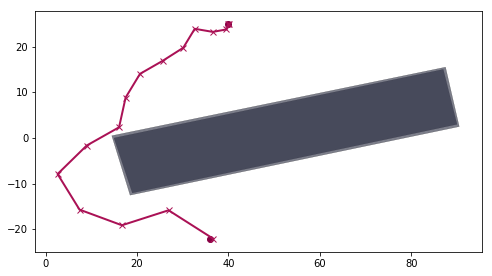

Meteoro! Melhor de todos:33928.746003187174 - count:21
Meteoro! Melhor de todos:31913.896914199326 - count:14
Meteoro! Melhor de todos:31906.920216859242 - count:14
Meteoro! Melhor de todos:31292.593080005103 - count:13
Meteoro! Melhor de todos:31025.691759559275 - count:14
Meteoro! Melhor de todos:30861.92219315032 - count:12
Meteoro! Melhor de todos:29978.239879697463 - count:20
Meteoro! Melhor de todos:29978.239879697463 - count:10
Meteoro! Melhor de todos:29978.239879697463 - count:13
Meteoro! Melhor de todos:29559.191671743367 - count:19
Meteoro! Melhor de todos:29559.191671743367 - count:14
Meteoro! Melhor de todos:29559.191671743367 - count:6
Meteoro! Melhor de todos:29559.191671743367 - count:12
Meteoro! Melhor de todos:29557.01888998535 - count:8
Meteoro! Melhor de todos:29351.784419340715 - count:27
Meteoro! Melhor de todos:29351.784419340715 - count:9
Meteoro! Melhor de todos:29292.38766575605 - count:24
Meteoro! Melhor de todos:29292.38766575605 - count:9
Meteoro! Melhor de

Meteoro! Melhor de todos:28948.115694121436 - count:10
Meteoro! Melhor de todos:28947.954090838684 - count:16
Meteoro! Melhor de todos:28927.40779150148 - count:28
Meteoro! Melhor de todos:28927.40779150148 - count:12
Meteoro! Melhor de todos:28927.40779150148 - count:11
Meteoro! Melhor de todos:28927.40779150148 - count:10
Meteoro! Melhor de todos:28925.501767269718 - count:15
Meteoro! Melhor de todos:28925.501767269718 - count:13
Meteoro! Melhor de todos:28925.501767269718 - count:14
Meteoro! Melhor de todos:28925.501767269718 - count:8
Meteoro! Melhor de todos:28923.76117728916 - count:14
Meteoro! Melhor de todos:28923.76117728916 - count:18
Meteoro! Melhor de todos:28923.76117728916 - count:13
Meteoro! Melhor de todos:28923.76117728916 - count:16
Meteoro! Melhor de todos:28923.76117728916 - count:11
Meteoro! Melhor de todos:28923.76117728916 - count:14
Meteoro! Melhor de todos:28923.76117728916 - count:18
Meteoro! Melhor de todos:28923.76117728916 - count:18
Meteoro! Melhor de todo

Meteoro! Melhor de todos:28853.30887692928 - count:9
Meteoro! Melhor de todos:28853.30887692928 - count:19
Meteoro! Melhor de todos:28853.30887692928 - count:14
Meteoro! Melhor de todos:28853.30887692928 - count:25
Meteoro! Melhor de todos:28853.30887692928 - count:15
Meteoro! Melhor de todos:28853.30887692928 - count:13
Meteoro! Melhor de todos:28853.30887692928 - count:14
Meteoro! Melhor de todos:28853.30887692928 - count:14
Meteoro! Melhor de todos:28853.30887692928 - count:16
Meteoro! Melhor de todos:28853.30887692928 - count:13
Meteoro! Melhor de todos:28853.30887692928 - count:18
Meteoro! Melhor de todos:28853.30887692928 - count:11
Meteoro! Melhor de todos:28853.30887692928 - count:5
Meteoro! Melhor de todos:28853.30887692928 - count:21
Meteoro! Melhor de todos:28853.30887692928 - count:8
Meteoro! Melhor de todos:28853.30887692928 - count:11
Meteoro! Melhor de todos:28853.30887692928 - count:14
Meteoro! Melhor de todos:28853.30887692928 - count:8
Meteoro! Melhor de todos:28853.3

Meteoro! Melhor de todos:28630.83625945045 - count:8
Meteoro! Melhor de todos:28630.83625945045 - count:12
Meteoro! Melhor de todos:28630.83625945045 - count:11
Meteoro! Melhor de todos:28630.83625945045 - count:11
Meteoro! Melhor de todos:28630.83625945045 - count:11
Meteoro! Melhor de todos:28630.83625945045 - count:5
Meteoro! Melhor de todos:28630.83625945045 - count:16
Meteoro! Melhor de todos:28630.83625945045 - count:13
Meteoro! Melhor de todos:28630.83625945045 - count:23
Meteoro! Melhor de todos:28630.83625945045 - count:7
Meteoro! Melhor de todos:28630.83625945045 - count:12
Meteoro! Melhor de todos:28630.83625945045 - count:26
Meteoro! Melhor de todos:28630.83625945045 - count:19
Meteoro! Melhor de todos:28630.83625945045 - count:10
Meteoro! Melhor de todos:28630.83625945045 - count:8
Meteoro! Melhor de todos:28630.83625945045 - count:15
Meteoro! Melhor de todos:28630.83625945045 - count:16
Meteoro! Melhor de todos:28630.83625945045 - count:12
Meteoro! Melhor de todos:28630.8

Meteoro! Melhor de todos:28557.39191636483 - count:11
Meteoro! Melhor de todos:28557.39191636483 - count:12
Meteoro! Melhor de todos:28557.39191636483 - count:12
Meteoro! Melhor de todos:28557.39191636483 - count:8
Meteoro! Melhor de todos:28557.39191636483 - count:15
Meteoro! Melhor de todos:28557.39191636483 - count:6
Meteoro! Melhor de todos:28557.39191636483 - count:9
Meteoro! Melhor de todos:28557.39191636483 - count:13
Meteoro! Melhor de todos:28557.39191636483 - count:10
Meteoro! Melhor de todos:28557.39191636483 - count:16
Meteoro! Melhor de todos:28557.39191636483 - count:16
Meteoro! Melhor de todos:28557.39191636483 - count:16
Meteoro! Melhor de todos:28557.39191636483 - count:7
Meteoro! Melhor de todos:28557.39191636483 - count:7
Meteoro! Melhor de todos:28557.39191636483 - count:18
Meteoro! Melhor de todos:28557.39191636483 - count:16
Meteoro! Melhor de todos:28557.39191636483 - count:20
Meteoro! Melhor de todos:28557.39191636483 - count:10
Meteoro! Melhor de todos:28557.39

Meteoro! Melhor de todos:28548.221399696475 - count:12
Meteoro! Melhor de todos:28548.221399696475 - count:17
Meteoro! Melhor de todos:28548.221399696475 - count:14
Meteoro! Melhor de todos:28548.221399696475 - count:18
Meteoro! Melhor de todos:28548.221399696475 - count:18
Meteoro! Melhor de todos:28544.97131173492 - count:64
Meteoro! Melhor de todos:28544.97131173492 - count:4
Meteoro! Melhor de todos:28544.97131173492 - count:15
Meteoro! Melhor de todos:28544.97131173492 - count:16
Meteoro! Melhor de todos:28544.97131173492 - count:15
Meteoro! Melhor de todos:28544.97131173492 - count:13
Meteoro! Melhor de todos:28544.97131173492 - count:10
Meteoro! Melhor de todos:28544.97131173492 - count:7
Meteoro! Melhor de todos:28544.97131173492 - count:21
Meteoro! Melhor de todos:28544.97131173492 - count:10
Meteoro! Melhor de todos:28544.97131173492 - count:31
Meteoro! Melhor de todos:28544.97131173492 - count:8
Meteoro! Melhor de todos:28544.061905674196 - count:23
Meteoro! Melhor de todos:

Meteoro! Melhor de todos:28529.657853305343 - count:9
Meteoro! Melhor de todos:28529.3699083416 - count:23
Meteoro! Melhor de todos:28529.3699083416 - count:19
Meteoro! Melhor de todos:28529.3699083416 - count:6
Meteoro! Melhor de todos:28529.3699083416 - count:9
Meteoro! Melhor de todos:28529.216156273098 - count:10
Meteoro! Melhor de todos:28529.216156273098 - count:6
Meteoro! Melhor de todos:28529.216156273098 - count:11
Meteoro! Melhor de todos:28529.216156273098 - count:8
Meteoro! Melhor de todos:28529.216156273098 - count:19
Meteoro! Melhor de todos:28529.216156273098 - count:17
Meteoro! Melhor de todos:28529.216156273098 - count:16
Meteoro! Melhor de todos:28528.581276037447 - count:13
Meteoro! Melhor de todos:28528.581276037447 - count:12
Meteoro! Melhor de todos:28528.581276037447 - count:18
Meteoro! Melhor de todos:28528.581276037447 - count:17
Meteoro! Melhor de todos:28528.581276037447 - count:7
Meteoro! Melhor de todos:28528.581276037447 - count:16
Meteoro! Melhor de todos

Meteoro! Melhor de todos:28510.313184752078 - count:17
Meteoro! Melhor de todos:28510.313184752078 - count:11
Meteoro! Melhor de todos:28510.313184752078 - count:21
Meteoro! Melhor de todos:28510.313184752078 - count:22
Meteoro! Melhor de todos:28510.313184752078 - count:10
Meteoro! Melhor de todos:28510.313184752078 - count:5
Meteoro! Melhor de todos:28510.313184752078 - count:10
Meteoro! Melhor de todos:28510.313184752078 - count:11
Meteoro! Melhor de todos:28510.313184752078 - count:20
Meteoro! Melhor de todos:28510.313184752078 - count:18
Meteoro! Melhor de todos:28507.05206754719 - count:9
Meteoro! Melhor de todos:28506.386829032974 - count:20
Meteoro! Melhor de todos:28504.16988782174 - count:44
Meteoro! Melhor de todos:28504.16988782174 - count:12
Meteoro! Melhor de todos:28504.16988782174 - count:8
Meteoro! Melhor de todos:28504.16988782174 - count:18
Meteoro! Melhor de todos:28504.16988782174 - count:14
Meteoro! Melhor de todos:28504.16988782174 - count:8
Meteoro! Melhor de to

Meteoro! Melhor de todos:28489.757911300534 - count:12
Meteoro! Melhor de todos:28489.757911300534 - count:9
Meteoro! Melhor de todos:28489.757911300534 - count:17
Meteoro! Melhor de todos:28489.757911300534 - count:10
Meteoro! Melhor de todos:28489.757911300534 - count:28
Meteoro! Melhor de todos:28489.757911300534 - count:17
Meteoro! Melhor de todos:28489.757911300534 - count:15
Meteoro! Melhor de todos:28489.757911300534 - count:13
Meteoro! Melhor de todos:28489.757911300534 - count:6
Meteoro! Melhor de todos:28489.757911300534 - count:7
Meteoro! Melhor de todos:28489.757911300534 - count:7
Meteoro! Melhor de todos:28489.757911300534 - count:24
Meteoro! Melhor de todos:28489.757911300534 - count:9
Meteoro! Melhor de todos:28489.757911300534 - count:12
Meteoro! Melhor de todos:28489.757911300534 - count:9
Meteoro! Melhor de todos:28489.757911300534 - count:10
Meteoro! Melhor de todos:28489.757911300534 - count:20
Meteoro! Melhor de todos:28489.757911300534 - count:9
Meteoro! Melhor d

Meteoro! Melhor de todos:28482.70015933274 - count:15
Meteoro! Melhor de todos:28482.70015933274 - count:19
Meteoro! Melhor de todos:28482.70015933274 - count:16
Meteoro! Melhor de todos:28482.70015933274 - count:7
Meteoro! Melhor de todos:28482.70015933274 - count:17
Meteoro! Melhor de todos:28482.6466995011 - count:21
Meteoro! Melhor de todos:28482.6466995011 - count:19
Meteoro! Melhor de todos:28482.6466995011 - count:12
Meteoro! Melhor de todos:28482.6466995011 - count:13
Meteoro! Melhor de todos:28482.6466995011 - count:13
Meteoro! Melhor de todos:28482.6466995011 - count:15
Meteoro! Melhor de todos:28482.6466995011 - count:25
Meteoro! Melhor de todos:28482.6466995011 - count:11
Meteoro! Melhor de todos:28482.6466995011 - count:17
Meteoro! Melhor de todos:28482.6466995011 - count:15
Meteoro! Melhor de todos:28482.6466995011 - count:4
Meteoro! Melhor de todos:28482.6466995011 - count:8
Meteoro! Melhor de todos:28482.6466995011 - count:10
Meteoro! Melhor de todos:28482.639486415614 

Meteoro! Melhor de todos:28481.47577474766 - count:17
Meteoro! Melhor de todos:28477.229063893104 - count:19
Meteoro! Melhor de todos:28477.229063893104 - count:13
Meteoro! Melhor de todos:28475.314551836815 - count:18
Meteoro! Melhor de todos:28471.504870770084 - count:16
Meteoro! Melhor de todos:28471.504870770084 - count:18
Meteoro! Melhor de todos:28471.504870770084 - count:9
Meteoro! Melhor de todos:28471.504870770084 - count:27
Meteoro! Melhor de todos:28471.504870770084 - count:19
Meteoro! Melhor de todos:28471.504870770084 - count:6
Meteoro! Melhor de todos:28471.504870770084 - count:14
Meteoro! Melhor de todos:28471.504870770084 - count:15
Meteoro! Melhor de todos:28471.504870770084 - count:23
Meteoro! Melhor de todos:28471.504870770084 - count:17
Meteoro! Melhor de todos:28471.504870770084 - count:6
Meteoro! Melhor de todos:28471.504870770084 - count:21
Meteoro! Melhor de todos:28471.504870770084 - count:19
Meteoro! Melhor de todos:28471.504870770084 - count:20
Meteoro! Melho

Meteoro! Melhor de todos:28461.354604438577 - count:11
Meteoro! Melhor de todos:28461.354604438577 - count:13
Meteoro! Melhor de todos:28461.331267054786 - count:17
Meteoro! Melhor de todos:28461.331267054786 - count:15
Meteoro! Melhor de todos:28461.331267054786 - count:9
Meteoro! Melhor de todos:28461.331267054786 - count:14
Meteoro! Melhor de todos:28461.331267054786 - count:25
Meteoro! Melhor de todos:28459.370530706423 - count:25
Meteoro! Melhor de todos:28459.370530706423 - count:5
Meteoro! Melhor de todos:28459.370530706423 - count:18
Meteoro! Melhor de todos:28459.370530706423 - count:15
Meteoro! Melhor de todos:28459.370530706423 - count:7
Meteoro! Melhor de todos:28459.370530706423 - count:14
Meteoro! Melhor de todos:28459.370530706423 - count:9
Meteoro! Melhor de todos:28459.370530706423 - count:12
Meteoro! Melhor de todos:28459.370530706423 - count:22
Meteoro! Melhor de todos:28459.370530706423 - count:15
Meteoro! Melhor de todos:28459.370530706423 - count:8
Meteoro! Melhor

Meteoro! Melhor de todos:28458.48248364653 - count:13
Meteoro! Melhor de todos:28458.48248364653 - count:24
Meteoro! Melhor de todos:28458.48248364653 - count:15
Meteoro! Melhor de todos:28458.48248364653 - count:15
Meteoro! Melhor de todos:28458.48248364653 - count:6
Meteoro! Melhor de todos:28444.441320240054 - count:20
Meteoro! Melhor de todos:28442.754000606536 - count:31
Meteoro! Melhor de todos:28441.219704463358 - count:12
Meteoro! Melhor de todos:28441.219704463358 - count:21
Meteoro! Melhor de todos:28441.219704463358 - count:17
Meteoro! Melhor de todos:28440.83818246907 - count:14
Meteoro! Melhor de todos:28400.07684638293 - count:32
Meteoro! Melhor de todos:28387.850555844776 - count:17
Meteoro! Melhor de todos:28387.850555844776 - count:9
Meteoro! Melhor de todos:28387.850555844776 - count:11
Meteoro! Melhor de todos:28387.850555844776 - count:13
Meteoro! Melhor de todos:28387.850555844776 - count:13
Meteoro! Melhor de todos:28382.250955338575 - count:69
Meteoro! Melhor de 

Meteoro! Melhor de todos:28362.08330191345 - count:10
Meteoro! Melhor de todos:28362.08330191345 - count:17
Meteoro! Melhor de todos:28362.08330191345 - count:18
Meteoro! Melhor de todos:28362.08330191345 - count:9
Meteoro! Melhor de todos:28362.08330191345 - count:20
Meteoro! Melhor de todos:28362.08330191345 - count:13
Meteoro! Melhor de todos:28362.08330191345 - count:12
Meteoro! Melhor de todos:28362.08330191345 - count:10
Meteoro! Melhor de todos:28362.08330191345 - count:13
Meteoro! Melhor de todos:28362.08133849079 - count:32
Meteoro! Melhor de todos:28362.08133849079 - count:12
Meteoro! Melhor de todos:28362.08133849079 - count:11
Meteoro! Melhor de todos:28362.08133849079 - count:12
Meteoro! Melhor de todos:28362.08133849079 - count:15
Meteoro! Melhor de todos:28362.08133849079 - count:7
Meteoro! Melhor de todos:28362.08133849079 - count:12
Meteoro! Melhor de todos:28362.08133849079 - count:11
Meteoro! Melhor de todos:28362.08133849079 - count:17
Meteoro! Melhor de todos:28362

Meteoro! Melhor de todos:28342.096616438608 - count:30
Meteoro! Melhor de todos:28342.096616438608 - count:13
Meteoro! Melhor de todos:28342.096616438608 - count:12
Meteoro! Melhor de todos:28342.096616438608 - count:11
Meteoro! Melhor de todos:28342.096616438608 - count:12
Meteoro! Melhor de todos:28342.096616438608 - count:12
Meteoro! Melhor de todos:28342.096616438608 - count:16
Meteoro! Melhor de todos:28342.096616438608 - count:13
Meteoro! Melhor de todos:28342.096616438608 - count:8
Meteoro! Melhor de todos:28342.096616438608 - count:13
Meteoro! Melhor de todos:28342.096616438608 - count:11
Meteoro! Melhor de todos:28342.096616438608 - count:4
Meteoro! Melhor de todos:28342.096616438608 - count:16
Meteoro! Melhor de todos:28342.096616438608 - count:19
Meteoro! Melhor de todos:28342.096616438608 - count:15
Meteoro! Melhor de todos:28342.096616438608 - count:13
Meteoro! Melhor de todos:28342.096616438608 - count:15
Meteoro! Melhor de todos:28342.096616438608 - count:11
Meteoro! Mel

Meteoro! Melhor de todos:28338.797122312415 - count:14
Meteoro! Melhor de todos:28338.797122312415 - count:15
Meteoro! Melhor de todos:28338.797122312415 - count:13
Meteoro! Melhor de todos:28338.797122312415 - count:8
Meteoro! Melhor de todos:28338.797122312415 - count:9
Meteoro! Melhor de todos:28338.797122312415 - count:15
Meteoro! Melhor de todos:28338.797122312415 - count:11
Meteoro! Melhor de todos:28338.797122312415 - count:5
Meteoro! Melhor de todos:28338.797122312415 - count:18
Meteoro! Melhor de todos:28338.797122312415 - count:10
Meteoro! Melhor de todos:28338.797122312415 - count:8
Meteoro! Melhor de todos:28338.797122312415 - count:11
Meteoro! Melhor de todos:28338.797122312415 - count:13
Meteoro! Melhor de todos:28338.797122312415 - count:22
Meteoro! Melhor de todos:28338.797122312415 - count:12
Meteoro! Melhor de todos:28338.797122312415 - count:15
Meteoro! Melhor de todos:28338.797122312415 - count:17
Meteoro! Melhor de todos:28338.797122312415 - count:15
Meteoro! Melho

Meteoro! Melhor de todos:28338.132983959465 - count:14
Meteoro! Melhor de todos:28338.132983959465 - count:11
Meteoro! Melhor de todos:28338.132983959465 - count:18
Meteoro! Melhor de todos:28338.132983959465 - count:19
Meteoro! Melhor de todos:28338.132158601813 - count:35
Meteoro! Melhor de todos:28338.132158601813 - count:23
Meteoro! Melhor de todos:28338.132158601813 - count:22
Meteoro! Melhor de todos:28338.132158601813 - count:6
Meteoro! Melhor de todos:28338.132158601813 - count:20
Meteoro! Melhor de todos:28338.132158601813 - count:21
Meteoro! Melhor de todos:28338.132158601813 - count:10
Meteoro! Melhor de todos:28338.132158601813 - count:11
Meteoro! Melhor de todos:28338.132158601813 - count:7
Meteoro! Melhor de todos:28338.132158601813 - count:16
Meteoro! Melhor de todos:28338.132158601813 - count:17
Meteoro! Melhor de todos:28338.132158601813 - count:10
Meteoro! Melhor de todos:28338.132158601813 - count:7
Meteoro! Melhor de todos:28338.132158601813 - count:24
Meteoro! Melh

Meteoro! Melhor de todos:28338.129164413345 - count:19
Meteoro! Melhor de todos:28338.129164413345 - count:12
Meteoro! Melhor de todos:28338.129164413345 - count:11
Meteoro! Melhor de todos:28338.129164413345 - count:20
Meteoro! Melhor de todos:28338.129164413345 - count:12
Meteoro! Melhor de todos:28338.129164413345 - count:30
Meteoro! Melhor de todos:28338.129164413345 - count:11
Meteoro! Melhor de todos:28338.129164413345 - count:24
Meteoro! Melhor de todos:28338.129164413345 - count:22
Meteoro! Melhor de todos:28338.129164413345 - count:25
Meteoro! Melhor de todos:28338.129164413345 - count:18
Meteoro! Melhor de todos:28338.129164413345 - count:11
Meteoro! Melhor de todos:28338.129164413345 - count:18
Meteoro! Melhor de todos:28338.129164413345 - count:15
Meteoro! Melhor de todos:28338.129164413345 - count:7
Meteoro! Melhor de todos:28338.129164413345 - count:11
Meteoro! Melhor de todos:28338.129164413345 - count:10
Meteoro! Melhor de todos:28338.129164413345 - count:11
Meteoro! Me

Meteoro! Melhor de todos:28338.128991931364 - count:15
Meteoro! Melhor de todos:28338.128991931364 - count:15
Meteoro! Melhor de todos:28338.128991931364 - count:16
Meteoro! Melhor de todos:28338.128991931364 - count:8
Meteoro! Melhor de todos:28338.128991931364 - count:10
Meteoro! Melhor de todos:28338.122175200406 - count:30
Meteoro! Melhor de todos:28338.122175200406 - count:12
Meteoro! Melhor de todos:28338.122175200406 - count:14
Meteoro! Melhor de todos:28338.122175200406 - count:17
Meteoro! Melhor de todos:28338.122175200406 - count:15
Meteoro! Melhor de todos:28338.122175200406 - count:20
Meteoro! Melhor de todos:28338.122175200406 - count:13
Meteoro! Melhor de todos:28338.122175200406 - count:12
Meteoro! Melhor de todos:28338.122175200406 - count:13
Meteoro! Melhor de todos:28338.122175200406 - count:21
Meteoro! Melhor de todos:28338.122175200406 - count:22
Meteoro! Melhor de todos:28338.122175200406 - count:7
Meteoro! Melhor de todos:28338.122175200406 - count:10
Meteoro! Mel

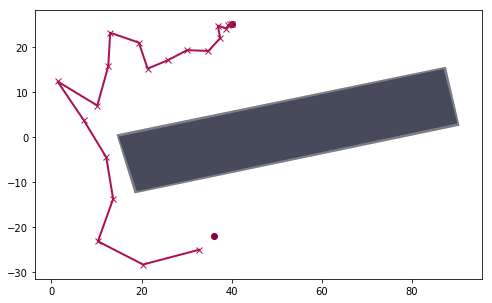

Meteoro! Melhor de todos:31813.343466806906 - count:46
Meteoro! Melhor de todos:30752.064203748476 - count:14
Meteoro! Melhor de todos:30750.992282793115 - count:21
Meteoro! Melhor de todos:30583.859695619187 - count:20
Meteoro! Melhor de todos:30583.859695619187 - count:13
Meteoro! Melhor de todos:30554.236597622556 - count:25
Meteoro! Melhor de todos:30554.236597622556 - count:7
Meteoro! Melhor de todos:30549.0310608962 - count:12
Meteoro! Melhor de todos:30538.596581030088 - count:37
Meteoro! Melhor de todos:30536.81757834003 - count:12
Meteoro! Melhor de todos:30536.81757834003 - count:18
Meteoro! Melhor de todos:30536.81757834003 - count:6
Meteoro! Melhor de todos:30536.81757834003 - count:14
Meteoro! Melhor de todos:30536.81757834003 - count:17
Meteoro! Melhor de todos:29790.52797121593 - count:19
Meteoro! Melhor de todos:29738.690998127757 - count:11
Meteoro! Melhor de todos:29306.994663807327 - count:23
Meteoro! Melhor de todos:29306.994663807327 - count:13
Meteoro! Melhor de t

Meteoro! Melhor de todos:28331.499849083728 - count:19
Meteoro! Melhor de todos:28331.499849083728 - count:15
Meteoro! Melhor de todos:28331.499849083728 - count:20
Meteoro! Melhor de todos:28331.499849083728 - count:13
Meteoro! Melhor de todos:28331.46918649067 - count:16
Meteoro! Melhor de todos:28331.46918649067 - count:15
Meteoro! Melhor de todos:28331.46918649067 - count:7
Meteoro! Melhor de todos:28331.46918649067 - count:11
Meteoro! Melhor de todos:28330.122907979956 - count:14
Meteoro! Melhor de todos:28330.122907979956 - count:10
Meteoro! Melhor de todos:28330.122907979956 - count:15
Meteoro! Melhor de todos:28330.122907979956 - count:15
Meteoro! Melhor de todos:28330.122907979956 - count:17
Meteoro! Melhor de todos:28330.122907979956 - count:6
Meteoro! Melhor de todos:28330.122907979956 - count:21
Meteoro! Melhor de todos:28330.122907979956 - count:22
Meteoro! Melhor de todos:28330.122907979956 - count:15
Meteoro! Melhor de todos:28330.122907979956 - count:11
Meteoro! Melhor 

Meteoro! Melhor de todos:28313.505903298086 - count:12
Meteoro! Melhor de todos:28313.505903298086 - count:15
Meteoro! Melhor de todos:28313.505903298086 - count:17
Meteoro! Melhor de todos:28313.505903298086 - count:18
Meteoro! Melhor de todos:28313.505903298086 - count:18
Meteoro! Melhor de todos:28313.505903298086 - count:16
Meteoro! Melhor de todos:28313.505903298086 - count:10
Meteoro! Melhor de todos:28313.505903298086 - count:8
Meteoro! Melhor de todos:28313.505903298086 - count:8
Meteoro! Melhor de todos:28313.505903298086 - count:22
Meteoro! Melhor de todos:28313.505903298086 - count:19
Meteoro! Melhor de todos:28313.505903298086 - count:16
Meteoro! Melhor de todos:28313.505903298086 - count:7
Meteoro! Melhor de todos:28313.505903298086 - count:20
Meteoro! Melhor de todos:28313.505903298086 - count:25
Meteoro! Melhor de todos:28313.505903298086 - count:10
Meteoro! Melhor de todos:28313.505903298086 - count:17
Meteoro! Melhor de todos:28313.505006439394 - count:26
Meteoro! Melh

Meteoro! Melhor de todos:28242.20556630523 - count:14
Meteoro! Melhor de todos:28242.20556630523 - count:14
Meteoro! Melhor de todos:28242.20556630523 - count:13
Meteoro! Melhor de todos:28242.20556630523 - count:13
Meteoro! Melhor de todos:28242.20556630523 - count:12
Meteoro! Melhor de todos:28242.20556630523 - count:15
Meteoro! Melhor de todos:28242.20556630523 - count:10
Meteoro! Melhor de todos:28241.89021090218 - count:44
Meteoro! Melhor de todos:28241.89021090218 - count:14
Meteoro! Melhor de todos:28241.89021090218 - count:16
Meteoro! Melhor de todos:28241.89021090218 - count:28
Meteoro! Melhor de todos:28241.89021090218 - count:8
Meteoro! Melhor de todos:28241.89021090218 - count:15
Meteoro! Melhor de todos:28241.89021090218 - count:14
Meteoro! Melhor de todos:28241.89021090218 - count:10
Meteoro! Melhor de todos:28241.89021090218 - count:11
Meteoro! Melhor de todos:28241.89021090218 - count:14
Meteoro! Melhor de todos:28241.89021090218 - count:28
Meteoro! Melhor de todos:2824

Meteoro! Melhor de todos:28235.971727701097 - count:24
Meteoro! Melhor de todos:28235.971727701097 - count:13
Meteoro! Melhor de todos:28235.931202478652 - count:16
Meteoro! Melhor de todos:28235.931202478652 - count:12
Meteoro! Melhor de todos:28235.931202478652 - count:7
Meteoro! Melhor de todos:28235.931202478652 - count:11
Meteoro! Melhor de todos:28235.931202478652 - count:12
Meteoro! Melhor de todos:28235.931202478652 - count:30
Meteoro! Melhor de todos:28235.931202478652 - count:13
Meteoro! Melhor de todos:28235.931202478652 - count:19
Meteoro! Melhor de todos:28235.931202478652 - count:11
Meteoro! Melhor de todos:28235.931202478652 - count:13
Meteoro! Melhor de todos:28235.931202478652 - count:16
Meteoro! Melhor de todos:28235.931202478652 - count:19
Meteoro! Melhor de todos:28235.931202478652 - count:18
Meteoro! Melhor de todos:28235.931202478652 - count:17
Meteoro! Melhor de todos:28235.931202478652 - count:19
Meteoro! Melhor de todos:28235.931202478652 - count:15
Meteoro! Me

Meteoro! Melhor de todos:28235.022439169978 - count:9
Meteoro! Melhor de todos:28235.022439169978 - count:15
Meteoro! Melhor de todos:28235.022439169978 - count:18
Meteoro! Melhor de todos:28235.022439169978 - count:12
Meteoro! Melhor de todos:28235.022439169978 - count:26
Meteoro! Melhor de todos:28235.022439169978 - count:11
Meteoro! Melhor de todos:28235.022439169978 - count:30
Meteoro! Melhor de todos:28235.022439169978 - count:17
Meteoro! Melhor de todos:28235.022439169978 - count:12
Meteoro! Melhor de todos:28235.022439169978 - count:16
Meteoro! Melhor de todos:28235.022439169978 - count:18
Meteoro! Melhor de todos:28235.022439169978 - count:7
Meteoro! Melhor de todos:28235.022439169978 - count:27
Meteoro! Melhor de todos:28235.022439169978 - count:9
Meteoro! Melhor de todos:28235.022439169978 - count:10
Meteoro! Melhor de todos:28235.022439169978 - count:10
Meteoro! Melhor de todos:28235.022439169978 - count:12
Meteoro! Melhor de todos:28235.022439169978 - count:33
Meteoro! Melh

Meteoro! Melhor de todos:28234.916088948532 - count:11
Meteoro! Melhor de todos:28234.916088948532 - count:20
Meteoro! Melhor de todos:28234.916088948532 - count:8
Meteoro! Melhor de todos:28234.916088948532 - count:13
Meteoro! Melhor de todos:28234.916088948532 - count:4
Meteoro! Melhor de todos:28234.916088948532 - count:11
Meteoro! Melhor de todos:28234.91360215591 - count:30
Meteoro! Melhor de todos:28234.91360215591 - count:17
Meteoro! Melhor de todos:28234.91360215591 - count:13
Meteoro! Melhor de todos:28234.91360215591 - count:24
Meteoro! Melhor de todos:28234.91360215591 - count:19
Meteoro! Melhor de todos:28234.91360215591 - count:9
Meteoro! Melhor de todos:28234.91360215591 - count:30
Meteoro! Melhor de todos:28234.91360215591 - count:15
Meteoro! Melhor de todos:28234.91360215591 - count:16
Meteoro! Melhor de todos:28234.91360215591 - count:15
Meteoro! Melhor de todos:28234.91360215591 - count:10
Meteoro! Melhor de todos:28234.91360215591 - count:7
Meteoro! Melhor de todos:2

Meteoro! Melhor de todos:28234.91360215591 - count:18
Meteoro! Melhor de todos:28234.91360215591 - count:24
Meteoro! Melhor de todos:28234.91360215591 - count:14
Meteoro! Melhor de todos:28234.91360215591 - count:16
Meteoro! Melhor de todos:28234.91360215591 - count:20
Meteoro! Melhor de todos:28234.91360215591 - count:14
Meteoro! Melhor de todos:28234.91360215591 - count:15
Meteoro! Melhor de todos:28234.91360215591 - count:13
Meteoro! Melhor de todos:28234.91360215591 - count:14
Meteoro! Melhor de todos:28234.91360215591 - count:15
Meteoro! Melhor de todos:28234.91360215591 - count:16
Meteoro! Melhor de todos:28234.91360215591 - count:22
Meteoro! Melhor de todos:28234.91360215591 - count:13
Meteoro! Melhor de todos:28234.91360215591 - count:9
Meteoro! Melhor de todos:28234.91360215591 - count:9
Meteoro! Melhor de todos:28234.91360215591 - count:17
Meteoro! Melhor de todos:28234.91360215591 - count:18
Meteoro! Melhor de todos:28234.91360215591 - count:17
Meteoro! Melhor de todos:28234

Meteoro! Melhor de todos:28230.782437064507 - count:16
Meteoro! Melhor de todos:28230.782437064507 - count:23
Meteoro! Melhor de todos:28230.782437064507 - count:23
Meteoro! Melhor de todos:28230.782437064507 - count:22
Meteoro! Melhor de todos:28230.782437064507 - count:9
Meteoro! Melhor de todos:28230.782437064507 - count:17
Meteoro! Melhor de todos:28230.782437064507 - count:14
Meteoro! Melhor de todos:28230.782437064507 - count:14
Meteoro! Melhor de todos:28230.782437064507 - count:20
Meteoro! Melhor de todos:28230.782437064507 - count:25
Meteoro! Melhor de todos:28230.782437064507 - count:17
Meteoro! Melhor de todos:28230.782437064507 - count:11
Meteoro! Melhor de todos:28230.782437064507 - count:17
Meteoro! Melhor de todos:28230.782437064507 - count:7
Meteoro! Melhor de todos:28230.782437064507 - count:8
Meteoro! Melhor de todos:28230.782437064507 - count:24
Meteoro! Melhor de todos:28230.782437064507 - count:20
Meteoro! Melhor de todos:28230.78031078843 - count:23
Meteoro! Melho

Meteoro! Melhor de todos:28207.942396168284 - count:9
Meteoro! Melhor de todos:28207.942396168284 - count:29
Meteoro! Melhor de todos:28207.942396168284 - count:11
Meteoro! Melhor de todos:28207.942396168284 - count:21
Meteoro! Melhor de todos:28207.942396168284 - count:13
Meteoro! Melhor de todos:28207.940263849327 - count:20
Meteoro! Melhor de todos:28207.940263849327 - count:10
Meteoro! Melhor de todos:28207.940263849327 - count:16
Meteoro! Melhor de todos:28207.940263849327 - count:18
Meteoro! Melhor de todos:28207.91762726594 - count:26
Meteoro! Melhor de todos:28207.91762726594 - count:12
Meteoro! Melhor de todos:28207.91762726594 - count:16
Meteoro! Melhor de todos:28207.91762726594 - count:15
Meteoro! Melhor de todos:28207.91762726594 - count:19
Meteoro! Melhor de todos:28207.91762726594 - count:13
Meteoro! Melhor de todos:28207.91762726594 - count:14
Meteoro! Melhor de todos:28207.91762726594 - count:22
Meteoro! Melhor de todos:28207.91762726594 - count:19
Meteoro! Melhor de t

Meteoro! Melhor de todos:28195.45347547941 - count:13
Meteoro! Melhor de todos:28195.45347547941 - count:16
Meteoro! Melhor de todos:28195.45347547941 - count:12
Meteoro! Melhor de todos:28195.45347547941 - count:15
Meteoro! Melhor de todos:28195.45347547941 - count:17
Meteoro! Melhor de todos:28195.45347547941 - count:15
Meteoro! Melhor de todos:28195.451459309155 - count:28
Meteoro! Melhor de todos:28195.451459309155 - count:9
Meteoro! Melhor de todos:28195.451459309155 - count:18
Meteoro! Melhor de todos:28195.451459309155 - count:14
Meteoro! Melhor de todos:28195.451459309155 - count:14
Meteoro! Melhor de todos:28195.451459309155 - count:16
Meteoro! Melhor de todos:28195.451459309155 - count:12
Meteoro! Melhor de todos:28195.451459309155 - count:35
Meteoro! Melhor de todos:28195.451459309155 - count:20
Meteoro! Melhor de todos:28195.451459309155 - count:17
Meteoro! Melhor de todos:28195.451459309155 - count:17
Meteoro! Melhor de todos:28195.451459309155 - count:30
Meteoro! Melhor d

Meteoro! Melhor de todos:6479.432369629019 - count:15
Meteoro! Melhor de todos:6479.432369629019 - count:10
Meteoro! Melhor de todos:6473.015195604142 - count:20
Meteoro! Melhor de todos:6473.015195604142 - count:10
Meteoro! Melhor de todos:6473.015195604142 - count:9
Meteoro! Melhor de todos:6473.015195604142 - count:8
Meteoro! Melhor de todos:6473.015195604142 - count:10
Meteoro! Melhor de todos:6473.015195604142 - count:5
Meteoro! Melhor de todos:6473.015195604142 - count:9
Meteoro! Melhor de todos:6473.015195604142 - count:6
Meteoro! Melhor de todos:6473.015195604142 - count:5
Meteoro! Melhor de todos:6473.015195604142 - count:14
Meteoro! Melhor de todos:6473.015195604142 - count:24
Meteoro! Melhor de todos:6473.015195604142 - count:18
Meteoro! Melhor de todos:6473.015195604142 - count:10
Meteoro! Melhor de todos:6473.015195604142 - count:11
Meteoro! Melhor de todos:6473.015195604142 - count:10
Meteoro! Melhor de todos:6473.015195604142 - count:11
Meteoro! Melhor de todos:6402.3793

Meteoro! Melhor de todos:4716.7339602043285 - count:28
Meteoro! Melhor de todos:4716.7339602043285 - count:11
Meteoro! Melhor de todos:4705.548840107273 - count:73
Meteoro! Melhor de todos:4705.548840107273 - count:13
Meteoro! Melhor de todos:4704.91209793304 - count:14
Meteoro! Melhor de todos:4704.91209793304 - count:5
Meteoro! Melhor de todos:4704.91209793304 - count:10
Meteoro! Melhor de todos:4704.91209793304 - count:12
Meteoro! Melhor de todos:4704.91209793304 - count:5
Meteoro! Melhor de todos:4704.91209793304 - count:16
Meteoro! Melhor de todos:4704.91209793304 - count:12
Meteoro! Melhor de todos:4704.91209793304 - count:9
Meteoro! Melhor de todos:4704.91209793304 - count:19
Meteoro! Melhor de todos:4704.91209793304 - count:13
Meteoro! Melhor de todos:4704.91209793304 - count:11
Meteoro! Melhor de todos:4704.91209793304 - count:15
Meteoro! Melhor de todos:4704.91209793304 - count:11
Meteoro! Melhor de todos:4704.91209793304 - count:13
Meteoro! Melhor de todos:4704.91209793304 -

Meteoro! Melhor de todos:4353.5270955429005 - count:11
Meteoro! Melhor de todos:4353.5270955429005 - count:6
Meteoro! Melhor de todos:4353.5270955429005 - count:11
Meteoro! Melhor de todos:4353.5270955429005 - count:10
Meteoro! Melhor de todos:4353.5270955429005 - count:11
Meteoro! Melhor de todos:4353.5270955429005 - count:14
Meteoro! Melhor de todos:4353.5270955429005 - count:7
Meteoro! Melhor de todos:4353.5213233121485 - count:15
Meteoro! Melhor de todos:4353.5213233121485 - count:13
Meteoro! Melhor de todos:4353.5213233121485 - count:13
Meteoro! Melhor de todos:4353.5213233121485 - count:9
Meteoro! Melhor de todos:4353.5213233121485 - count:12
Meteoro! Melhor de todos:4353.5213233121485 - count:8
Meteoro! Melhor de todos:4353.5213233121485 - count:19
Meteoro! Melhor de todos:4353.5213233121485 - count:17
Meteoro! Melhor de todos:4353.5213233121485 - count:7
Meteoro! Melhor de todos:4353.5213233121485 - count:6
Meteoro! Melhor de todos:4353.5213233121485 - count:14
Meteoro! Melhor 

Meteoro! Melhor de todos:4350.758033010335 - count:8
Meteoro! Melhor de todos:4350.758033010335 - count:6
Meteoro! Melhor de todos:4350.758033010335 - count:10
Meteoro! Melhor de todos:4350.758033010335 - count:16
Meteoro! Melhor de todos:4350.758033010335 - count:14
Meteoro! Melhor de todos:4350.758033010335 - count:19
Meteoro! Melhor de todos:4350.758033010335 - count:10
Meteoro! Melhor de todos:4350.758033010335 - count:15
Meteoro! Melhor de todos:4350.758033010335 - count:28
Meteoro! Melhor de todos:4350.758033010335 - count:12
Meteoro! Melhor de todos:4350.758033010335 - count:17
Meteoro! Melhor de todos:4350.758033010335 - count:9
Meteoro! Melhor de todos:4350.758033010335 - count:11
Meteoro! Melhor de todos:4350.758033010335 - count:5
Meteoro! Melhor de todos:4350.758033010335 - count:15
Meteoro! Melhor de todos:4350.758033010335 - count:8
Meteoro! Melhor de todos:4350.758033010335 - count:23
Meteoro! Melhor de todos:4350.758033010335 - count:14
Meteoro! Melhor de todos:4350.758

Meteoro! Melhor de todos:4166.691351332773 - count:10
Meteoro! Melhor de todos:4166.691351332773 - count:11
Meteoro! Melhor de todos:4166.691351332773 - count:16
Meteoro! Melhor de todos:4166.691351332773 - count:16
Meteoro! Melhor de todos:4166.691351332773 - count:9
Meteoro! Melhor de todos:4166.691351332773 - count:11
Meteoro! Melhor de todos:4166.691351332773 - count:12
Meteoro! Melhor de todos:4166.691351332773 - count:15
Meteoro! Melhor de todos:4166.691351332773 - count:9
Meteoro! Melhor de todos:4166.691351332773 - count:12
Meteoro! Melhor de todos:4166.691351332773 - count:7
Meteoro! Melhor de todos:4166.691351332773 - count:7
Meteoro! Melhor de todos:4166.691351332773 - count:16
Meteoro! Melhor de todos:4166.691351332773 - count:13
Meteoro! Melhor de todos:4166.691351332773 - count:14
Meteoro! Melhor de todos:4166.691351332773 - count:14
Meteoro! Melhor de todos:4166.691351332773 - count:9
Meteoro! Melhor de todos:4166.691351332773 - count:5
Meteoro! Melhor de todos:4166.6913

Meteoro! Melhor de todos:4141.759773797121 - count:7
Meteoro! Melhor de todos:4141.759773797121 - count:11
Meteoro! Melhor de todos:4141.759773797121 - count:17
Meteoro! Melhor de todos:4141.759773797121 - count:17
Meteoro! Melhor de todos:4141.40771693001 - count:7
Meteoro! Melhor de todos:4141.40771693001 - count:6
Meteoro! Melhor de todos:4141.40771693001 - count:11
Meteoro! Melhor de todos:4141.40771693001 - count:12
Meteoro! Melhor de todos:4141.40771693001 - count:6
Meteoro! Melhor de todos:4141.40771693001 - count:10
Meteoro! Melhor de todos:4138.737555144477 - count:17
Meteoro! Melhor de todos:4138.737555144477 - count:4
Meteoro! Melhor de todos:4138.737555144477 - count:19
Meteoro! Melhor de todos:4138.737555144477 - count:20
Meteoro! Melhor de todos:4138.737555144477 - count:6
Meteoro! Melhor de todos:4138.737555144477 - count:15
Meteoro! Melhor de todos:4138.737555144477 - count:11
Meteoro! Melhor de todos:4138.737555144477 - count:22
Meteoro! Melhor de todos:4136.7753478344

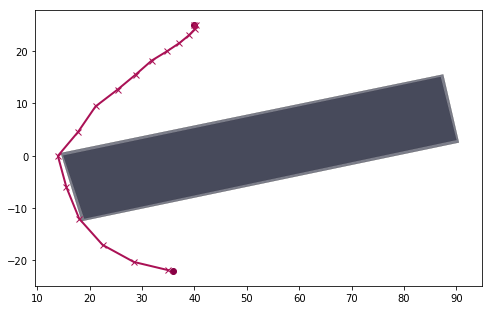

Meteoro! Melhor de todos:31394.92489536454 - count:31
Meteoro! Melhor de todos:31330.722026821993 - count:11
Meteoro! Melhor de todos:30154.69438891128 - count:29
Meteoro! Melhor de todos:30105.74395973091 - count:16
Meteoro! Melhor de todos:30105.74395973091 - count:12
Meteoro! Melhor de todos:30105.74395973091 - count:19
Meteoro! Melhor de todos:29548.169871374193 - count:32
Meteoro! Melhor de todos:29548.169871374193 - count:9
Meteoro! Melhor de todos:28869.351217520412 - count:23
Meteoro! Melhor de todos:28865.656839806747 - count:89
Meteoro! Melhor de todos:28865.656839806747 - count:9
Meteoro! Melhor de todos:28865.656839806747 - count:14
Meteoro! Melhor de todos:28865.656839806747 - count:21
Meteoro! Melhor de todos:28865.656839806747 - count:17
Meteoro! Melhor de todos:28865.656839806747 - count:22
Meteoro! Melhor de todos:28865.656839806747 - count:21
Meteoro! Melhor de todos:28865.656839806747 - count:16
Meteoro! Melhor de todos:28865.656839806747 - count:16
Meteoro! Melhor d

Meteoro! Melhor de todos:28527.449288718806 - count:53
Meteoro! Melhor de todos:28527.449288718806 - count:21
Meteoro! Melhor de todos:28527.449288718806 - count:18
Meteoro! Melhor de todos:28527.449288718806 - count:18
Meteoro! Melhor de todos:28527.449288718806 - count:19
Meteoro! Melhor de todos:28527.449288718806 - count:16
Meteoro! Melhor de todos:28527.449288718806 - count:19
Meteoro! Melhor de todos:28527.449288718806 - count:12
Meteoro! Melhor de todos:28525.10197593602 - count:30
Meteoro! Melhor de todos:28525.10197593602 - count:13
Meteoro! Melhor de todos:28525.10197593602 - count:15
Meteoro! Melhor de todos:28525.10197593602 - count:23
Meteoro! Melhor de todos:28525.10197593602 - count:8
Meteoro! Melhor de todos:28525.10197593602 - count:7
Meteoro! Melhor de todos:28524.04632702555 - count:27
Meteoro! Melhor de todos:28520.166630428084 - count:50
Meteoro! Melhor de todos:28519.63000689011 - count:24
Meteoro! Melhor de todos:28519.63000689011 - count:8
Meteoro! Melhor de tod

Meteoro! Melhor de todos:28465.922890006754 - count:23
Meteoro! Melhor de todos:28465.922890006754 - count:11
Meteoro! Melhor de todos:28465.922890006754 - count:18
Meteoro! Melhor de todos:28465.121563634668 - count:120
Meteoro! Melhor de todos:28465.121563634668 - count:13
Meteoro! Melhor de todos:28465.121563634668 - count:11
Meteoro! Melhor de todos:28465.121563634668 - count:20
Meteoro! Melhor de todos:28465.121563634668 - count:24
Meteoro! Melhor de todos:28465.121563634668 - count:15
Meteoro! Melhor de todos:28465.121563634668 - count:18
Meteoro! Melhor de todos:28465.121563634668 - count:9
Meteoro! Melhor de todos:28465.121563634668 - count:16
Meteoro! Melhor de todos:28465.121563634668 - count:16
Meteoro! Melhor de todos:28465.121563634668 - count:8
Meteoro! Melhor de todos:28465.121563634668 - count:11
Meteoro! Melhor de todos:28465.121563634668 - count:14
Meteoro! Melhor de todos:28465.121563634668 - count:24
Meteoro! Melhor de todos:28465.121563634668 - count:14
Meteoro! Me

Meteoro! Melhor de todos:28464.68681803957 - count:12
Meteoro! Melhor de todos:28464.68681803957 - count:19
Meteoro! Melhor de todos:28464.661506735945 - count:20
Meteoro! Melhor de todos:28464.660249825287 - count:14
Meteoro! Melhor de todos:28464.660249825287 - count:16
Meteoro! Melhor de todos:28464.660249825287 - count:5
Meteoro! Melhor de todos:28464.660249825287 - count:10
Meteoro! Melhor de todos:28464.660249825287 - count:15
Meteoro! Melhor de todos:28464.660249825287 - count:9
Meteoro! Melhor de todos:28464.660249825287 - count:20
Meteoro! Melhor de todos:28464.660249825287 - count:12
Meteoro! Melhor de todos:28464.660249825287 - count:13
Meteoro! Melhor de todos:28464.660249825287 - count:19
Meteoro! Melhor de todos:28464.660249825287 - count:14
Meteoro! Melhor de todos:28464.660249825287 - count:16
Meteoro! Melhor de todos:28464.660249825287 - count:11
Meteoro! Melhor de todos:28464.660249825287 - count:13
Meteoro! Melhor de todos:28464.660249825287 - count:18
Meteoro! Melho

Meteoro! Melhor de todos:28455.942464986878 - count:23
Meteoro! Melhor de todos:28455.942464986878 - count:20
Meteoro! Melhor de todos:28454.97932610004 - count:37
Meteoro! Melhor de todos:28454.97932610004 - count:12
Meteoro! Melhor de todos:28454.97932610004 - count:17
Meteoro! Melhor de todos:28454.97932610004 - count:18
Meteoro! Melhor de todos:28454.97932610004 - count:8
Meteoro! Melhor de todos:28454.97932610004 - count:18
Meteoro! Melhor de todos:28454.97932610004 - count:13
Meteoro! Melhor de todos:28454.97932610004 - count:22
Meteoro! Melhor de todos:28454.97932610004 - count:14
Meteoro! Melhor de todos:28454.97932610004 - count:15
Meteoro! Melhor de todos:28454.97932610004 - count:7
Meteoro! Melhor de todos:28454.97932610004 - count:8
Meteoro! Melhor de todos:28454.97932610004 - count:14
Meteoro! Melhor de todos:28454.97932610004 - count:7
Meteoro! Melhor de todos:28454.97932610004 - count:18
Meteoro! Melhor de todos:28454.97932610004 - count:18
Meteoro! Melhor de todos:28454

Meteoro! Melhor de todos:28263.038109613735 - count:13
Meteoro! Melhor de todos:28263.038109613735 - count:12
Meteoro! Melhor de todos:28263.038109613735 - count:8
Meteoro! Melhor de todos:28263.038109613735 - count:16
Meteoro! Melhor de todos:28263.038109613735 - count:9
Meteoro! Melhor de todos:28263.038109613735 - count:11
Meteoro! Melhor de todos:28263.038109613735 - count:17
Meteoro! Melhor de todos:28263.038109613735 - count:23
Meteoro! Melhor de todos:28263.038109613735 - count:13
Meteoro! Melhor de todos:28263.038109613735 - count:18
Meteoro! Melhor de todos:28263.038109613735 - count:10
Meteoro! Melhor de todos:28263.038109613735 - count:10
Meteoro! Melhor de todos:28263.038109613735 - count:16
Meteoro! Melhor de todos:28263.038109613735 - count:15
Meteoro! Melhor de todos:28263.038109613735 - count:25
Meteoro! Melhor de todos:28263.038109613735 - count:14
Meteoro! Melhor de todos:28263.038109613735 - count:11
Meteoro! Melhor de todos:28263.038109613735 - count:13
Meteoro! Mel

Meteoro! Melhor de todos:28258.757174928105 - count:13
Meteoro! Melhor de todos:28258.757174928105 - count:25
Meteoro! Melhor de todos:28258.757174928105 - count:15
Meteoro! Melhor de todos:28258.757174928105 - count:18
Meteoro! Melhor de todos:28258.757174928105 - count:14
Meteoro! Melhor de todos:28258.757174928105 - count:19
Meteoro! Melhor de todos:28258.757174928105 - count:21
Meteoro! Melhor de todos:28258.757174928105 - count:16
Meteoro! Melhor de todos:28258.757174928105 - count:15
Meteoro! Melhor de todos:28258.757174928105 - count:17
Meteoro! Melhor de todos:28258.757174928105 - count:14
Meteoro! Melhor de todos:28258.757174928105 - count:15
Meteoro! Melhor de todos:28258.757174928105 - count:19
Meteoro! Melhor de todos:28258.757174928105 - count:19
Meteoro! Melhor de todos:28258.757174928105 - count:11
Meteoro! Melhor de todos:28258.757174928105 - count:19
Meteoro! Melhor de todos:28258.757174928105 - count:15
Meteoro! Melhor de todos:28258.757174928105 - count:11
Meteoro! M

Meteoro! Melhor de todos:28256.89833192637 - count:24
Meteoro! Melhor de todos:28256.89833192637 - count:24
Meteoro! Melhor de todos:28256.89833192637 - count:23
Meteoro! Melhor de todos:28256.89833192637 - count:12
Meteoro! Melhor de todos:28256.89833192637 - count:16
Meteoro! Melhor de todos:28256.89833192637 - count:14
Meteoro! Melhor de todos:28256.89833192637 - count:30
Meteoro! Melhor de todos:28256.89833192637 - count:26
Meteoro! Melhor de todos:28256.89833192637 - count:13
Meteoro! Melhor de todos:28256.89833192637 - count:32
Meteoro! Melhor de todos:28256.89833192637 - count:21
Meteoro! Melhor de todos:28256.89833192637 - count:25
Meteoro! Melhor de todos:28256.89833192637 - count:13
Meteoro! Melhor de todos:28256.6566522903 - count:22
Meteoro! Melhor de todos:28256.6566522903 - count:22
Meteoro! Melhor de todos:28256.6566522903 - count:19
Meteoro! Melhor de todos:28250.471960707833 - count:18
Meteoro! Melhor de todos:28250.471960707833 - count:16
Meteoro! Melhor de todos:2825

Meteoro! Melhor de todos:28247.819455624973 - count:11
Meteoro! Melhor de todos:28247.819455624973 - count:17
Meteoro! Melhor de todos:28247.819455624973 - count:25
Meteoro! Melhor de todos:28247.819455624973 - count:23
Meteoro! Melhor de todos:28247.819455624973 - count:23
Meteoro! Melhor de todos:28247.819455624973 - count:12
Meteoro! Melhor de todos:28247.819455624973 - count:17
Meteoro! Melhor de todos:28247.819455624973 - count:9
Meteoro! Melhor de todos:28247.819455624973 - count:7
Meteoro! Melhor de todos:28247.819455624973 - count:11
Meteoro! Melhor de todos:28247.819455624973 - count:8
Meteoro! Melhor de todos:28247.819455624973 - count:9
Meteoro! Melhor de todos:28247.819455624973 - count:15
Meteoro! Melhor de todos:28247.819455624973 - count:10
Meteoro! Melhor de todos:28247.819455624973 - count:24
Meteoro! Melhor de todos:28247.819455624973 - count:13
Meteoro! Melhor de todos:28247.819455624973 - count:11
Meteoro! Melhor de todos:28247.819455624973 - count:22
Meteoro! Melho

Meteoro! Melhor de todos:28247.812899600714 - count:12
Meteoro! Melhor de todos:28247.812899600714 - count:7
Meteoro! Melhor de todos:28247.812899600714 - count:14
Meteoro! Melhor de todos:28247.812899600714 - count:23
Meteoro! Melhor de todos:28247.812899600714 - count:17
Meteoro! Melhor de todos:28247.812899600714 - count:13
Meteoro! Melhor de todos:28247.812899600714 - count:9
Meteoro! Melhor de todos:28247.812899600714 - count:22
Meteoro! Melhor de todos:28247.812899600714 - count:26
Meteoro! Melhor de todos:28247.812899600714 - count:17
Meteoro! Melhor de todos:28247.812899600714 - count:29
Meteoro! Melhor de todos:28247.812899600714 - count:5
Meteoro! Melhor de todos:28247.812899600714 - count:15
Meteoro! Melhor de todos:28247.812899600714 - count:7
Meteoro! Melhor de todos:28247.812899600714 - count:24
Meteoro! Melhor de todos:28247.812899600714 - count:10
Meteoro! Melhor de todos:28247.812899600714 - count:16
Meteoro! Melhor de todos:28247.812899600714 - count:7
Meteoro! Melhor

Meteoro! Melhor de todos:28235.20112575163 - count:17
Meteoro! Melhor de todos:28235.20112575163 - count:24
Meteoro! Melhor de todos:28235.20112575163 - count:18
Meteoro! Melhor de todos:28235.20112575163 - count:16
Meteoro! Melhor de todos:28235.20112575163 - count:21
Meteoro! Melhor de todos:28235.20112575163 - count:7
Meteoro! Melhor de todos:28235.20112575163 - count:17
Meteoro! Melhor de todos:28235.20112575163 - count:15
Meteoro! Melhor de todos:28235.20112575163 - count:16
Meteoro! Melhor de todos:28235.20112575163 - count:10
Meteoro! Melhor de todos:28235.20112575163 - count:25
Meteoro! Melhor de todos:28235.20112575163 - count:14
Meteoro! Melhor de todos:28235.20112575163 - count:16
Meteoro! Melhor de todos:28235.20112575163 - count:24
Meteoro! Melhor de todos:28235.20112575163 - count:25
Meteoro! Melhor de todos:28235.20112575163 - count:22
Meteoro! Melhor de todos:28235.20112575163 - count:10
Meteoro! Melhor de todos:28235.20112575163 - count:23
Meteoro! Melhor de todos:2823

Meteoro! Melhor de todos:28234.498036144243 - count:18
Meteoro! Melhor de todos:28234.498036144243 - count:13
Meteoro! Melhor de todos:28234.498036144243 - count:15
Meteoro! Melhor de todos:28234.498036144243 - count:30
Meteoro! Melhor de todos:28234.498036144243 - count:14
Meteoro! Melhor de todos:28234.498036144243 - count:14
Meteoro! Melhor de todos:28234.498036144243 - count:13
Meteoro! Melhor de todos:28234.498036144243 - count:8
Meteoro! Melhor de todos:28234.498036144243 - count:11
Meteoro! Melhor de todos:28234.498036144243 - count:23
Meteoro! Melhor de todos:28234.498036144243 - count:9
Meteoro! Melhor de todos:28234.498036144243 - count:13
Meteoro! Melhor de todos:28234.498036144243 - count:16
Meteoro! Melhor de todos:28234.498036144243 - count:19
Meteoro! Melhor de todos:28234.498036144243 - count:16
Meteoro! Melhor de todos:28234.498036144243 - count:6
Meteoro! Melhor de todos:28234.498036144243 - count:12
Meteoro! Melhor de todos:28234.498036144243 - count:16
Meteoro! Melh

Meteoro! Melhor de todos:28234.483214558197 - count:16
Meteoro! Melhor de todos:28234.483214558197 - count:21
Meteoro! Melhor de todos:28234.483214558197 - count:15
Meteoro! Melhor de todos:28234.483214558197 - count:20
Meteoro! Melhor de todos:28234.483214558197 - count:32
Meteoro! Melhor de todos:28234.483214558197 - count:9
Meteoro! Melhor de todos:28234.483214558197 - count:24
Meteoro! Melhor de todos:28234.483214558197 - count:22
Meteoro! Melhor de todos:28234.483214558197 - count:15
Meteoro! Melhor de todos:28234.483214558197 - count:31
Meteoro! Melhor de todos:28234.483214558197 - count:17
Meteoro! Melhor de todos:28234.483214558197 - count:26
Meteoro! Melhor de todos:28234.483214558197 - count:5
Meteoro! Melhor de todos:28234.483214558197 - count:11
Meteoro! Melhor de todos:28234.483214558197 - count:15
Meteoro! Melhor de todos:28234.483214558197 - count:10
Meteoro! Melhor de todos:28234.483214558197 - count:10
Meteoro! Melhor de todos:28234.483214558197 - count:9
Meteoro! Melh

Meteoro! Melhor de todos:28234.483077525503 - count:17
Meteoro! Melhor de todos:28234.483077525503 - count:20
Meteoro! Melhor de todos:28234.483077525503 - count:17
Meteoro! Melhor de todos:28234.483077525503 - count:21
Meteoro! Melhor de todos:28234.483077525503 - count:16
Meteoro! Melhor de todos:28234.483077525503 - count:18
Meteoro! Melhor de todos:28234.483077525503 - count:23
Meteoro! Melhor de todos:28234.483077525503 - count:16
Meteoro! Melhor de todos:28234.483077525503 - count:10
Meteoro! Melhor de todos:28234.483077525503 - count:24
Meteoro! Melhor de todos:28234.483077525503 - count:13
Meteoro! Melhor de todos:28234.483077525503 - count:9
Meteoro! Melhor de todos:28234.483077525503 - count:13
Meteoro! Melhor de todos:28234.483077525503 - count:12
Meteoro! Melhor de todos:28234.483077525503 - count:14
Meteoro! Melhor de todos:28234.483077525503 - count:25
Meteoro! Melhor de todos:28234.483077525503 - count:9
Meteoro! Melhor de todos:28234.483077525503 - count:15
Meteoro! Mel

Meteoro! Melhor de todos:28161.786569087122 - count:14
Meteoro! Melhor de todos:28161.786569087122 - count:11
Meteoro! Melhor de todos:28161.786569087122 - count:18
Meteoro! Melhor de todos:28161.786569087122 - count:26
Meteoro! Melhor de todos:28161.786569087122 - count:21
Meteoro! Melhor de todos:28161.786569087122 - count:11
Meteoro! Melhor de todos:28161.786569087122 - count:16
Meteoro! Melhor de todos:28161.786569087122 - count:27
Meteoro! Melhor de todos:28161.786569087122 - count:9
Meteoro! Melhor de todos:28161.786569087122 - count:11
Meteoro! Melhor de todos:28161.786569087122 - count:21
Meteoro! Melhor de todos:28161.786569087122 - count:19
Meteoro! Melhor de todos:28161.786569087122 - count:11
Meteoro! Melhor de todos:28161.786569087122 - count:17
Meteoro! Melhor de todos:28161.786569087122 - count:14
Meteoro! Melhor de todos:28161.786569087122 - count:14
Meteoro! Melhor de todos:28161.786569087122 - count:13
Meteoro! Melhor de todos:28161.786569087122 - count:15
Meteoro! Me

Meteoro! Melhor de todos:28149.20564716447 - count:15
Meteoro! Melhor de todos:28149.20564716447 - count:26
Meteoro! Melhor de todos:28149.20564716447 - count:15
Meteoro! Melhor de todos:28149.20564716447 - count:9
Meteoro! Melhor de todos:28149.20564716447 - count:15
Meteoro! Melhor de todos:28149.20564716447 - count:10
Meteoro! Melhor de todos:28149.20564716447 - count:7
Meteoro! Melhor de todos:28149.20564716447 - count:18
Meteoro! Melhor de todos:28149.20564716447 - count:15
Meteoro! Melhor de todos:28149.20564716447 - count:4
Meteoro! Melhor de todos:28149.20564716447 - count:12
Meteoro! Melhor de todos:28149.20564716447 - count:11
Meteoro! Melhor de todos:28149.20564716447 - count:10
Meteoro! Melhor de todos:28149.20564716447 - count:10
Meteoro! Melhor de todos:28149.20564716447 - count:24
Meteoro! Melhor de todos:28149.20564716447 - count:8
Meteoro! Melhor de todos:28149.20564716447 - count:15
Meteoro! Melhor de todos:28149.20564716447 - count:12
Meteoro! Melhor de todos:28149.2

Meteoro! Melhor de todos:28136.56670848932 - count:13
Meteoro! Melhor de todos:28136.56670848932 - count:18
Meteoro! Melhor de todos:28136.56670848932 - count:22
Meteoro! Melhor de todos:28136.56670848932 - count:11
Meteoro! Melhor de todos:28136.56670848932 - count:12
Meteoro! Melhor de todos:28136.56670848932 - count:12
Meteoro! Melhor de todos:28136.56670848932 - count:17
Meteoro! Melhor de todos:28136.55937355911 - count:28
Meteoro! Melhor de todos:28136.55937355911 - count:8
Meteoro! Melhor de todos:28136.55937355911 - count:13
Meteoro! Melhor de todos:28136.55937355911 - count:13
Meteoro! Melhor de todos:28136.55937355911 - count:12
Meteoro! Melhor de todos:28136.55937355911 - count:15
Meteoro! Melhor de todos:28136.55937355911 - count:28
Meteoro! Melhor de todos:28136.55937355911 - count:9
Meteoro! Melhor de todos:28136.55937355911 - count:18
Meteoro! Melhor de todos:28136.55937355911 - count:16
Meteoro! Melhor de todos:28136.55937355911 - count:15
Meteoro! Melhor de todos:28136

Meteoro! Melhor de todos:28136.42949158654 - count:18
Meteoro! Melhor de todos:28136.42949158654 - count:15
Meteoro! Melhor de todos:28136.42949158654 - count:14
Meteoro! Melhor de todos:28136.42949158654 - count:16
Meteoro! Melhor de todos:28136.42949158654 - count:18
Meteoro! Melhor de todos:28136.42949158654 - count:12
Meteoro! Melhor de todos:28136.42949158654 - count:21
Meteoro! Melhor de todos:28136.42949158654 - count:14
Meteoro! Melhor de todos:28136.42949158654 - count:10
Meteoro! Melhor de todos:28136.42949158654 - count:19
Meteoro! Melhor de todos:28136.42949158654 - count:12
Meteoro! Melhor de todos:28136.42949158654 - count:13
Meteoro! Melhor de todos:28136.42949158654 - count:9
Meteoro! Melhor de todos:28136.42949158654 - count:28
Meteoro! Melhor de todos:28136.42949158654 - count:10
Meteoro! Melhor de todos:28136.42949158654 - count:19
Meteoro! Melhor de todos:28136.42949158654 - count:36
Meteoro! Melhor de todos:28136.42949158654 - count:31
Meteoro! Melhor de todos:2813

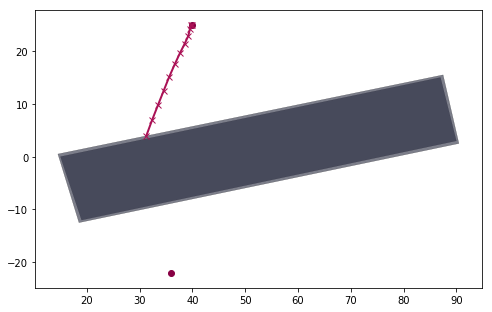

Meteoro! Melhor de todos:33420.534799200366 - count:16
Meteoro! Melhor de todos:33420.534799200366 - count:6
Meteoro! Melhor de todos:33420.534799200366 - count:8
Meteoro! Melhor de todos:26617.49299418693 - count:9
Meteoro! Melhor de todos:26617.49299418693 - count:16
Meteoro! Melhor de todos:26617.49299418693 - count:19
Meteoro! Melhor de todos:26617.49299418693 - count:12
Meteoro! Melhor de todos:26617.49299418693 - count:13
Meteoro! Melhor de todos:26617.49299418693 - count:20
Meteoro! Melhor de todos:26617.49299418693 - count:11
Meteoro! Melhor de todos:26617.49299418693 - count:7
Meteoro! Melhor de todos:21977.262686283433 - count:12
Meteoro! Melhor de todos:20665.71470554928 - count:14
Meteoro! Melhor de todos:16330.062180568644 - count:10
Meteoro! Melhor de todos:16330.062180568644 - count:9
Meteoro! Melhor de todos:16330.062180568644 - count:26
Meteoro! Melhor de todos:16330.062180568644 - count:13
Meteoro! Melhor de todos:16330.062180568644 - count:17
Meteoro! Melhor de todos

Meteoro! Melhor de todos:5945.528545552539 - count:9
Meteoro! Melhor de todos:5945.528545552539 - count:14
Meteoro! Melhor de todos:5945.506943703567 - count:13
Meteoro! Melhor de todos:5945.486283057995 - count:15
Meteoro! Melhor de todos:5945.486283057995 - count:8
Meteoro! Melhor de todos:5944.950992143983 - count:32
Meteoro! Melhor de todos:5944.950992143983 - count:6
Meteoro! Melhor de todos:5880.075973213129 - count:25
Meteoro! Melhor de todos:5872.897077756732 - count:12
Meteoro! Melhor de todos:5872.897077756732 - count:10
Meteoro! Melhor de todos:5872.897077756732 - count:10
Meteoro! Melhor de todos:5872.897077756732 - count:10
Meteoro! Melhor de todos:5859.098996349242 - count:54
Meteoro! Melhor de todos:5718.120317428336 - count:142
Meteoro! Melhor de todos:5718.11704260818 - count:24
Meteoro! Melhor de todos:5718.11704260818 - count:6
Meteoro! Melhor de todos:5717.841780037705 - count:12
Meteoro! Melhor de todos:5717.841780037705 - count:19
Meteoro! Melhor de todos:5717.841

Meteoro! Melhor de todos:4845.273704268161 - count:20
Meteoro! Melhor de todos:4845.273704268161 - count:18
Meteoro! Melhor de todos:4845.2572913494805 - count:13
Meteoro! Melhor de todos:4845.2572913494805 - count:10
Meteoro! Melhor de todos:4845.2572913494805 - count:14
Meteoro! Melhor de todos:4845.2572913494805 - count:20
Meteoro! Melhor de todos:4845.2572913494805 - count:8
Meteoro! Melhor de todos:4845.2572913494805 - count:22
Meteoro! Melhor de todos:4845.2572913494805 - count:20
Meteoro! Melhor de todos:4845.2572913494805 - count:7
Meteoro! Melhor de todos:4845.246750471559 - count:33
Meteoro! Melhor de todos:4845.246750471559 - count:13
Meteoro! Melhor de todos:4845.2467504387505 - count:11
Meteoro! Melhor de todos:4845.2467504387505 - count:10
Meteoro! Melhor de todos:4845.234496223968 - count:65
Meteoro! Melhor de todos:4845.234496223968 - count:13
Meteoro! Melhor de todos:4845.234496223968 - count:5
Meteoro! Melhor de todos:4845.234496223968 - count:18
Meteoro! Melhor de to

Meteoro! Melhor de todos:4824.113611873227 - count:8
Meteoro! Melhor de todos:4824.113609604305 - count:29
Meteoro! Melhor de todos:4824.113609604305 - count:25
Meteoro! Melhor de todos:4824.113609604305 - count:11
Meteoro! Melhor de todos:4824.113609604305 - count:22
Meteoro! Melhor de todos:4824.113609604305 - count:7
Meteoro! Melhor de todos:4824.113609604305 - count:9
Meteoro! Melhor de todos:4824.113609604305 - count:11
Meteoro! Melhor de todos:4824.113609604305 - count:8
Meteoro! Melhor de todos:4824.113609604305 - count:5
Meteoro! Melhor de todos:4824.068215957388 - count:30
Meteoro! Melhor de todos:4824.068215957388 - count:24
Meteoro! Melhor de todos:4824.068215957388 - count:22
Meteoro! Melhor de todos:4824.068215957388 - count:6
Meteoro! Melhor de todos:4824.068215957388 - count:9
Meteoro! Melhor de todos:4824.068215957388 - count:9
Meteoro! Melhor de todos:4824.068215957388 - count:10
Meteoro! Melhor de todos:4824.068215957388 - count:21
Meteoro! Melhor de todos:4824.068215

Meteoro! Melhor de todos:4820.334834327205 - count:34
Meteoro! Melhor de todos:4820.334834327205 - count:28
Meteoro! Melhor de todos:4820.334834327205 - count:19
Meteoro! Melhor de todos:4820.334833294579 - count:28
Meteoro! Melhor de todos:4820.334833294579 - count:19
Meteoro! Melhor de todos:4820.334833294579 - count:8
Meteoro! Melhor de todos:4820.334833294579 - count:16
Meteoro! Melhor de todos:4820.334806116595 - count:27
Meteoro! Melhor de todos:4820.334806116595 - count:9
Meteoro! Melhor de todos:4820.334806116595 - count:12
Meteoro! Melhor de todos:4820.334806116595 - count:16
Meteoro! Melhor de todos:4820.334806116595 - count:11
Meteoro! Melhor de todos:4820.334806116595 - count:17
Meteoro! Melhor de todos:4820.334806116595 - count:5
Meteoro! Melhor de todos:4820.334806116595 - count:8
Meteoro! Melhor de todos:4820.334806116595 - count:14
Meteoro! Melhor de todos:4820.334806116595 - count:19
Meteoro! Melhor de todos:4820.334806116595 - count:16
Meteoro! Melhor de todos:4820.33

Meteoro! Melhor de todos:4820.094691100341 - count:11
Meteoro! Melhor de todos:4820.094691100341 - count:7
Meteoro! Melhor de todos:4820.094691100341 - count:5
Meteoro! Melhor de todos:4820.094691100341 - count:7
Meteoro! Melhor de todos:4820.094691100341 - count:6
Meteoro! Melhor de todos:4820.094691100341 - count:14
Meteoro! Melhor de todos:4820.094691100341 - count:17
Meteoro! Melhor de todos:4820.094691100341 - count:15
Meteoro! Melhor de todos:4820.094691100341 - count:11
Meteoro! Melhor de todos:4820.094691100341 - count:10
Meteoro! Melhor de todos:4820.094691100341 - count:18
Meteoro! Melhor de todos:4820.094679343513 - count:44
Meteoro! Melhor de todos:4820.094679343513 - count:12
Meteoro! Melhor de todos:4820.094679343513 - count:9
Meteoro! Melhor de todos:4820.094679343513 - count:7
Meteoro! Melhor de todos:4820.094679343513 - count:25
Meteoro! Melhor de todos:4820.094679343513 - count:48
Meteoro! Melhor de todos:4820.094679343513 - count:11
Meteoro! Melhor de todos:4820.0946

Meteoro! Melhor de todos:4820.08330284124 - count:14
Meteoro! Melhor de todos:4820.08330284124 - count:20
Meteoro! Melhor de todos:4820.08330284124 - count:19
Meteoro! Melhor de todos:4820.08330284124 - count:6
Meteoro! Melhor de todos:4820.08330284124 - count:14
Meteoro! Melhor de todos:4820.08330284124 - count:12
Meteoro! Melhor de todos:4820.08330284124 - count:7
Meteoro! Melhor de todos:4820.08330284124 - count:16
Meteoro! Melhor de todos:4820.08330284124 - count:8
Meteoro! Melhor de todos:4820.08330284124 - count:6
Meteoro! Melhor de todos:4820.08330284124 - count:23
Meteoro! Melhor de todos:4820.08330284124 - count:14
Meteoro! Melhor de todos:4820.08330284124 - count:17
Meteoro! Melhor de todos:4820.08330284124 - count:13
Meteoro! Melhor de todos:4820.044885492518 - count:16
Meteoro! Melhor de todos:4820.044885492518 - count:6
Meteoro! Melhor de todos:4820.044885492518 - count:15
Meteoro! Melhor de todos:4820.044885492518 - count:15
Meteoro! Melhor de todos:4820.044885492518 - co

Meteoro! Melhor de todos:4817.107449352025 - count:11
Meteoro! Melhor de todos:4817.107449352025 - count:16
Meteoro! Melhor de todos:4817.107449352025 - count:8
Meteoro! Melhor de todos:4817.107449352025 - count:8
Meteoro! Melhor de todos:4817.107449352025 - count:9
Meteoro! Melhor de todos:4817.107449352025 - count:18
Meteoro! Melhor de todos:4817.107449352025 - count:19
Meteoro! Melhor de todos:4817.107449352025 - count:17
Meteoro! Melhor de todos:4817.107449352025 - count:19
Meteoro! Melhor de todos:4817.107449352025 - count:15
Meteoro! Melhor de todos:4817.107449352025 - count:10
Meteoro! Melhor de todos:4817.107449352025 - count:8
Meteoro! Melhor de todos:4817.107449352025 - count:17
Meteoro! Melhor de todos:4817.105118008512 - count:39
Meteoro! Melhor de todos:4817.105118008512 - count:10
Meteoro! Melhor de todos:4817.105118008512 - count:15
Meteoro! Melhor de todos:4817.105118008512 - count:7
Meteoro! Melhor de todos:4817.105118008512 - count:25
Meteoro! Melhor de todos:4817.105

Meteoro! Melhor de todos:4814.561283434836 - count:9
Meteoro! Melhor de todos:4814.561283434836 - count:11
Meteoro! Melhor de todos:4814.561283434836 - count:16
Meteoro! Melhor de todos:4814.561283434836 - count:8
Meteoro! Melhor de todos:4814.561283434836 - count:24
Meteoro! Melhor de todos:4814.561283434836 - count:17
Meteoro! Melhor de todos:4814.561283434836 - count:6
Meteoro! Melhor de todos:4814.561283434836 - count:11
Meteoro! Melhor de todos:4814.561283434836 - count:8
Meteoro! Melhor de todos:4814.561283434836 - count:12
Meteoro! Melhor de todos:4814.561283434836 - count:21
Meteoro! Melhor de todos:4814.521937197233 - count:28
Meteoro! Melhor de todos:4814.521937197233 - count:10
Meteoro! Melhor de todos:4814.520962651329 - count:69
Meteoro! Melhor de todos:4814.520962651329 - count:11
Meteoro! Melhor de todos:4814.520962651329 - count:6
Meteoro! Melhor de todos:4814.520962651329 - count:10
Meteoro! Melhor de todos:4814.520962651329 - count:10
Meteoro! Melhor de todos:4814.520

Meteoro! Melhor de todos:4814.425552783858 - count:12
Meteoro! Melhor de todos:4814.425552783858 - count:10
Meteoro! Melhor de todos:4814.425552783858 - count:21
Meteoro! Melhor de todos:4814.425552783858 - count:19
Meteoro! Melhor de todos:4814.425552783858 - count:29
Meteoro! Melhor de todos:4814.425552783858 - count:10
Meteoro! Melhor de todos:4814.425552783858 - count:22
Meteoro! Melhor de todos:4814.425552783858 - count:12
Meteoro! Melhor de todos:4814.425552783858 - count:14
Meteoro! Melhor de todos:4814.425552783858 - count:10
Meteoro! Melhor de todos:4814.425552783858 - count:9
Meteoro! Melhor de todos:4814.425552783858 - count:22
Meteoro! Melhor de todos:4814.425552783858 - count:10
Meteoro! Melhor de todos:4814.425552783858 - count:11
Meteoro! Melhor de todos:4814.425552783858 - count:32
Meteoro! Melhor de todos:4814.425552783858 - count:14
Meteoro! Melhor de todos:4814.425552783858 - count:15
Meteoro! Melhor de todos:4814.425552783858 - count:11
Meteoro! Melhor de todos:4814

Meteoro! Melhor de todos:4814.097840151839 - count:10
Meteoro! Melhor de todos:4814.097840151839 - count:23
Meteoro! Melhor de todos:4814.097840151839 - count:13
Meteoro! Melhor de todos:4814.09603331463 - count:46
Meteoro! Melhor de todos:4814.09603331463 - count:45
Meteoro! Melhor de todos:4814.09603331463 - count:15
Meteoro! Melhor de todos:4814.09603331463 - count:10
Meteoro! Melhor de todos:4814.09603331463 - count:7
Meteoro! Melhor de todos:4814.09603331463 - count:17
Meteoro! Melhor de todos:4814.09603331463 - count:11
Meteoro! Melhor de todos:4814.09603331463 - count:22
Meteoro! Melhor de todos:4814.09603331463 - count:10
Meteoro! Melhor de todos:4814.09603331463 - count:13
Meteoro! Melhor de todos:4814.09603331463 - count:19
Meteoro! Melhor de todos:4814.09603331463 - count:14
Meteoro! Melhor de todos:4814.09603331463 - count:13
Meteoro! Melhor de todos:4814.09603331463 - count:7
Meteoro! Melhor de todos:4814.09603331463 - count:14
Meteoro! Melhor de todos:4814.09603331463 - c

Meteoro! Melhor de todos:4813.712062071612 - count:12
Meteoro! Melhor de todos:4813.7113108834 - count:37
Meteoro! Melhor de todos:4813.7113108834 - count:15
Meteoro! Melhor de todos:4813.68236471714 - count:15
Meteoro! Melhor de todos:4813.68236471714 - count:16
Meteoro! Melhor de todos:4813.68236471714 - count:10
Meteoro! Melhor de todos:4813.68236471714 - count:9
Meteoro! Melhor de todos:4813.678136870933 - count:19
Meteoro! Melhor de todos:4813.6724188545195 - count:27
Meteoro! Melhor de todos:4813.6724188545195 - count:16
Meteoro! Melhor de todos:4813.6724188545195 - count:14
Meteoro! Melhor de todos:4813.6724188545195 - count:22
Meteoro! Melhor de todos:4813.6724188545195 - count:8
Meteoro! Melhor de todos:4813.6724188545195 - count:12
Meteoro! Melhor de todos:4813.6724188545195 - count:10
Meteoro! Melhor de todos:4813.6724188545195 - count:10
Meteoro! Melhor de todos:4813.6724188545195 - count:9
Meteoro! Melhor de todos:4813.666998949831 - count:20
Meteoro! Melhor de todos:4813.

Meteoro! Melhor de todos:4813.558997818994 - count:14
Meteoro! Melhor de todos:4813.558997818994 - count:6
Meteoro! Melhor de todos:4813.558997818994 - count:25
Meteoro! Melhor de todos:4813.558997818994 - count:8
Meteoro! Melhor de todos:4813.558997818994 - count:26
Meteoro! Melhor de todos:4813.558997818994 - count:10
Meteoro! Melhor de todos:4813.558997818994 - count:14
Meteoro! Melhor de todos:4813.558997818994 - count:15
Meteoro! Melhor de todos:4813.558997818994 - count:21
Meteoro! Melhor de todos:4813.558997818994 - count:7
Meteoro! Melhor de todos:4813.558997818994 - count:15
Meteoro! Melhor de todos:4813.558997818994 - count:9
Meteoro! Melhor de todos:4813.558997818994 - count:10
Meteoro! Melhor de todos:4813.558997818994 - count:15
Meteoro! Melhor de todos:4813.558897326764 - count:13
Meteoro! Melhor de todos:4813.558897326764 - count:9
Meteoro! Melhor de todos:4813.558897326764 - count:11
Meteoro! Melhor de todos:4813.558897326764 - count:24
Meteoro! Melhor de todos:4813.558

Meteoro! Melhor de todos:4813.539180923419 - count:10
Meteoro! Melhor de todos:4813.539180923419 - count:16
Meteoro! Melhor de todos:4813.539180923419 - count:6
Meteoro! Melhor de todos:4813.539180923419 - count:17
Meteoro! Melhor de todos:4813.539180923419 - count:34
Meteoro! Melhor de todos:4813.539180923419 - count:22
Meteoro! Melhor de todos:4813.539180923419 - count:12
Meteoro! Melhor de todos:4813.538817641778 - count:22
Meteoro! Melhor de todos:4813.538817641778 - count:18
Meteoro! Melhor de todos:4813.538817641778 - count:20
Meteoro! Melhor de todos:4813.538817641778 - count:9
Meteoro! Melhor de todos:4813.538775846316 - count:19
Meteoro! Melhor de todos:4813.538775846316 - count:21
Meteoro! Melhor de todos:4813.538775846316 - count:9
Meteoro! Melhor de todos:4813.538556199001 - count:22
Meteoro! Melhor de todos:4813.538556199001 - count:17
Meteoro! Melhor de todos:4813.538556199001 - count:24
Meteoro! Melhor de todos:4813.538556199001 - count:6
Meteoro! Melhor de todos:4813.53

Meteoro! Melhor de todos:4813.351140005656 - count:12
Meteoro! Melhor de todos:4813.351140005656 - count:15
Meteoro! Melhor de todos:4813.351140005656 - count:9
Meteoro! Melhor de todos:4813.351140005656 - count:13
Meteoro! Melhor de todos:4813.351140005656 - count:9
Meteoro! Melhor de todos:4813.351140005656 - count:9
Meteoro! Melhor de todos:4813.35111080844 - count:18
Meteoro! Melhor de todos:4813.35111080844 - count:22
Meteoro! Melhor de todos:4813.35111080844 - count:22
Meteoro! Melhor de todos:4813.35111080844 - count:7
Meteoro! Melhor de todos:4813.35111080844 - count:10
Meteoro! Melhor de todos:4813.35111080844 - count:20
Meteoro! Melhor de todos:4813.35111080844 - count:9
Meteoro! Melhor de todos:4813.35111080844 - count:14
Meteoro! Melhor de todos:4813.35111080844 - count:25
Meteoro! Melhor de todos:4813.35111080844 - count:10
Meteoro! Melhor de todos:4813.35111080844 - count:10
Meteoro! Melhor de todos:4813.35111080844 - count:16
Meteoro! Melhor de todos:4813.35111080844 - c

Meteoro! Melhor de todos:4813.35070421022 - count:12
Meteoro! Melhor de todos:4813.35070421022 - count:8
Meteoro! Melhor de todos:4813.35070421022 - count:23
Meteoro! Melhor de todos:4813.35070421022 - count:12
Meteoro! Melhor de todos:4813.35070421022 - count:9
Meteoro! Melhor de todos:4813.35070421022 - count:12
Meteoro! Melhor de todos:4813.35070421022 - count:21
Meteoro! Melhor de todos:4813.35070421022 - count:17
Meteoro! Melhor de todos:4813.35070421022 - count:23
Meteoro! Melhor de todos:4813.35070421022 - count:9
Meteoro! Melhor de todos:4813.35070421022 - count:18
Meteoro! Melhor de todos:4813.35070421022 - count:10
Meteoro! Melhor de todos:4813.35070421022 - count:22
Meteoro! Melhor de todos:4813.35070421022 - count:5
Meteoro! Melhor de todos:4813.35070421022 - count:25
Meteoro! Melhor de todos:4813.35070421022 - count:12
Meteoro! Melhor de todos:4813.35070421022 - count:30
Meteoro! Melhor de todos:4813.35070421022 - count:15
Meteoro! Melhor de todos:4813.35070421022 - count:

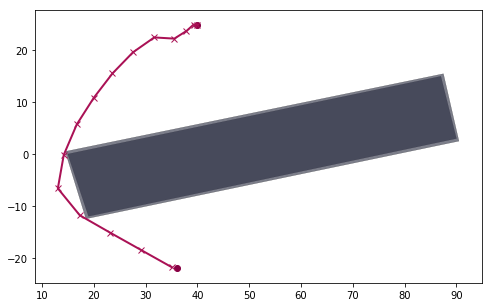

In [28]:
import pickle

for i in range(5):
    for selected_map, mapa in zip(['mapa4'], [mapa_4]):
        ag = run_ag(mapa)
        tests[selected_map]['ags'].append(ag)
        
        l = [[subject.fitness, subject.birth_time] for subject in ag.ancestry]   
        tests[selected_map]['res'].append(l)
        
        pickle.dump(tests, open( 'backups/20min_{}_{}.p'.format(selected_map, str(i)), 'wb' ) )

pickle.dump(tests, open('execution_20min_D.p', 'wb'))

In [29]:
pickle.dump(tests, open( "aasave_alpha.p", "wb" ) )

In [ ]:
import pickle
tests = pickle.load(open( "save_alpha.p", "rb" ) )

## Import

In [ ]:
test_backup = pickle.load(open( "execution_1.p", "rb" ) )

## Visualization

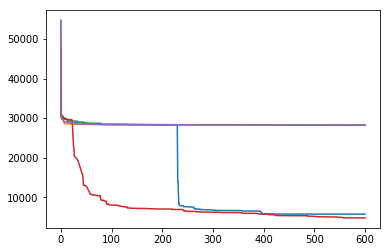

In [24]:
for i in range(5):
    np_ar = np.array(tests['mapa4']['res'][i])
    plt.plot(np_ar[:,1], np_ar[:,0])

In [ ]:
for i in range(1):
    np_ar = np.array(test_backup['mapa2']['res'][i])
    plt.plot(np_ar[:,1], np_ar[:,0])

# TODO

In [ ]:
# TODO1: Setar a semente do random para controlar o experimento
# TODO1: Printar o tempo que encontra cada melhor
# TODO1: Ter certeza na conversão de latitutde e longitude <- confiavel   (Veronica)

In [ ]:
Monografia
- até domingo - sobrar somente resultados
- ler os abstracts dos principais artigos
- achar ref pro Ray casting (google scholar: ray casting / ray casting GA / RC path planning) 
      foco pra imagens (citar) 
    rc com ga, mesmo que em outra area
    só ler abstract (os mais novos)
    ate onde nos pudermos pesquisar nessa monografia, nos nao encontramos trabalhos

- durante a semana so sobra os resultados


- retornar no domingo (a noite) ou segunda (noite): apresentar a monografia
    a medida que concluir uma seção, enviar